#### 생성기의 특정 노드를 끄면 날카로운 (맥시멈 라이클리후드의 결과물처럼 뽀얀 상태에서 어딘가 손생된 듯한) 이미지가 생성될 것인가?

In [27]:
import torch
from torch import nn
import torch.nn.functional as F

class My_Encoder(nn.Module):
    def __init__(self, dim_encoder_output, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(784, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, dim_encoder_output)

    def forward(self, x):
        x = self.fln(x)
        h = self.activation(self.l0(x))
        h = self.activation(self.l1(h))
        z = self.l2(h)
        return z


class My_Decoder(nn.Module):
    def __init__(self, dim_decoder_input, activation='tanh'):
        super().__init__()
        if activation == "tanh":
            self.activation = torch.tanh
        self.l0 = nn.Linear(dim_decoder_input, 512)
        self.l1 = nn.Linear(512, 512)
        self.l2 = nn.Linear(512, 784)
        self.unfln = nn.Unflatten(1, [1, 28, 28])

    def forward(self, z):
        x_hat = self.activation(self.l0(z))
        x_hat = self.activation(self.l1(x_hat))
        x_hat = torch.sigmoid(self.l2(x_hat))
        x_hat = self.unfln(x_hat)
        return x_hat

    def step_1(self, z):
        h = self.activation(self.l0(z))
        h = self.activation(self.l1(h))
        return h

    def step_2(self, h):
        x_hat = torch.sigmoid(self.l2(h))
        x_hat = self.unfln(x_hat)
        return x_hat


In [12]:
from myAE import Manager

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(2), My_Decoder(2))

def calc_loss(model, x, y, F, device):
    z = model.get_submodule("encoder")(x)
    x_hat = model.get_submodule("decoder")(z)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=30)

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:23<00:00,  4.79s/it]


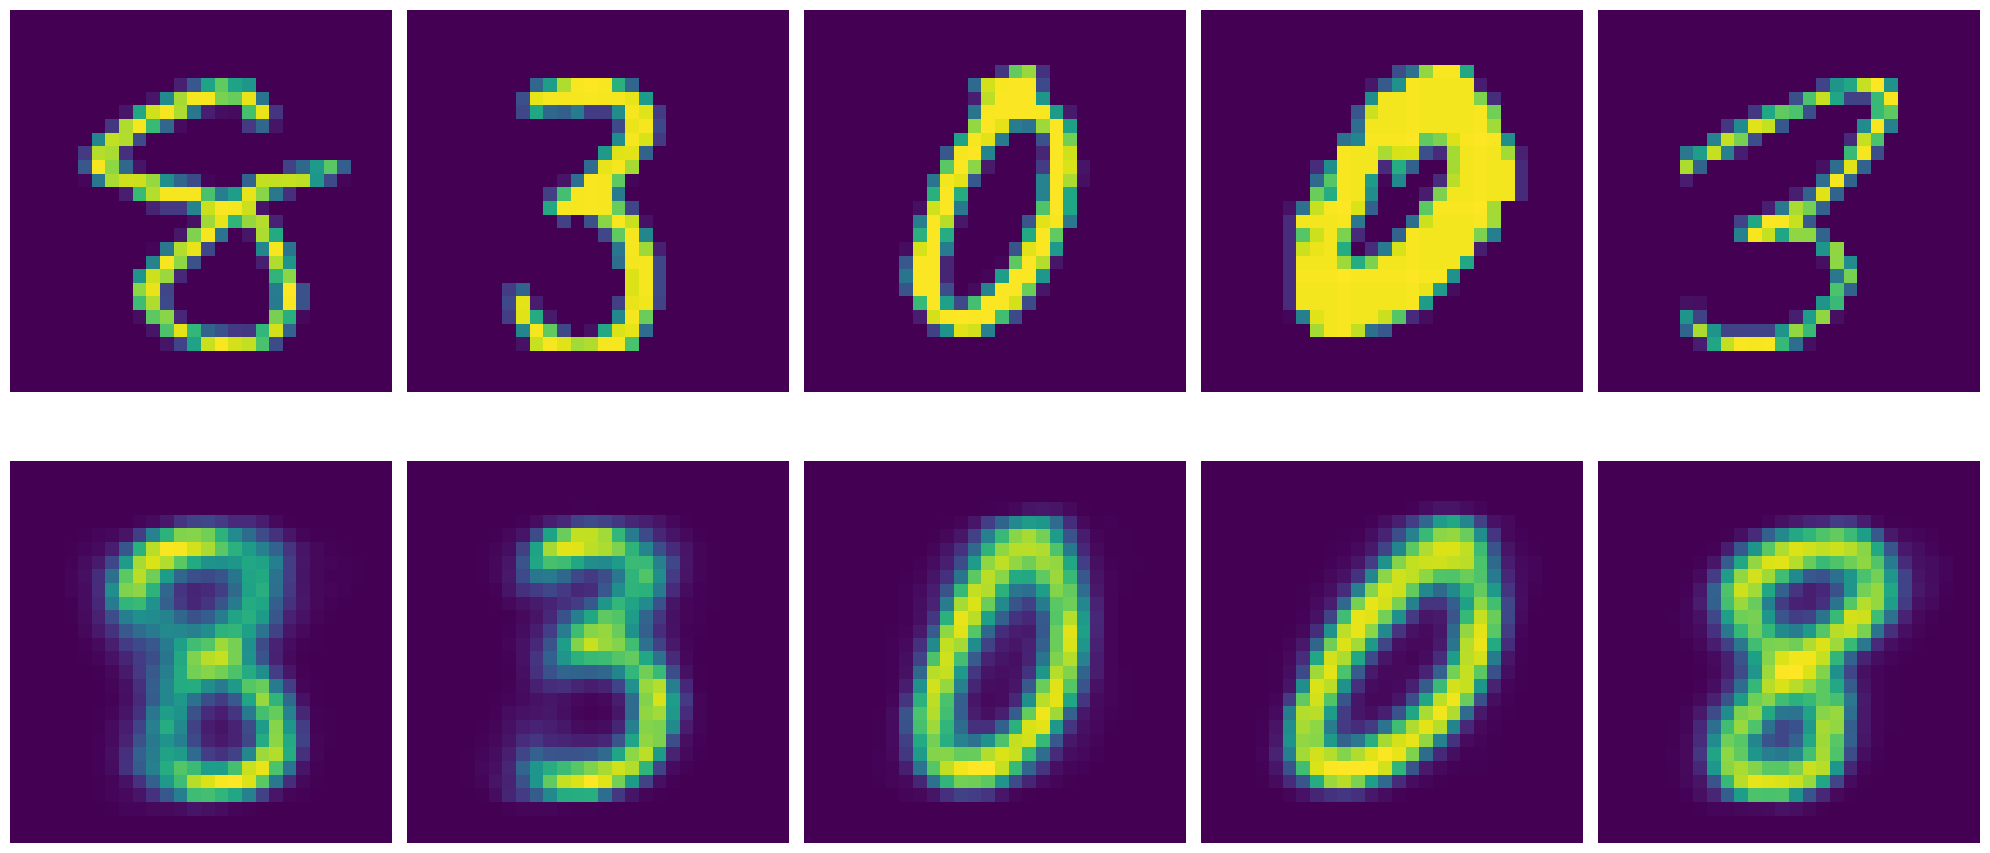

In [13]:
import matplotlib.pyplot as plt

fig, (axs1, axs2) = plt.subplots(nrows=2, ncols=5, figsize=[20, 10])

manager.model.to('cpu')
manager.model.eval()

for x, y in manager.train_dataloader:
    with torch.no_grad():
        x_hats = manager.model(x[:5])
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x_hats):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    break
plt.tight_layout()

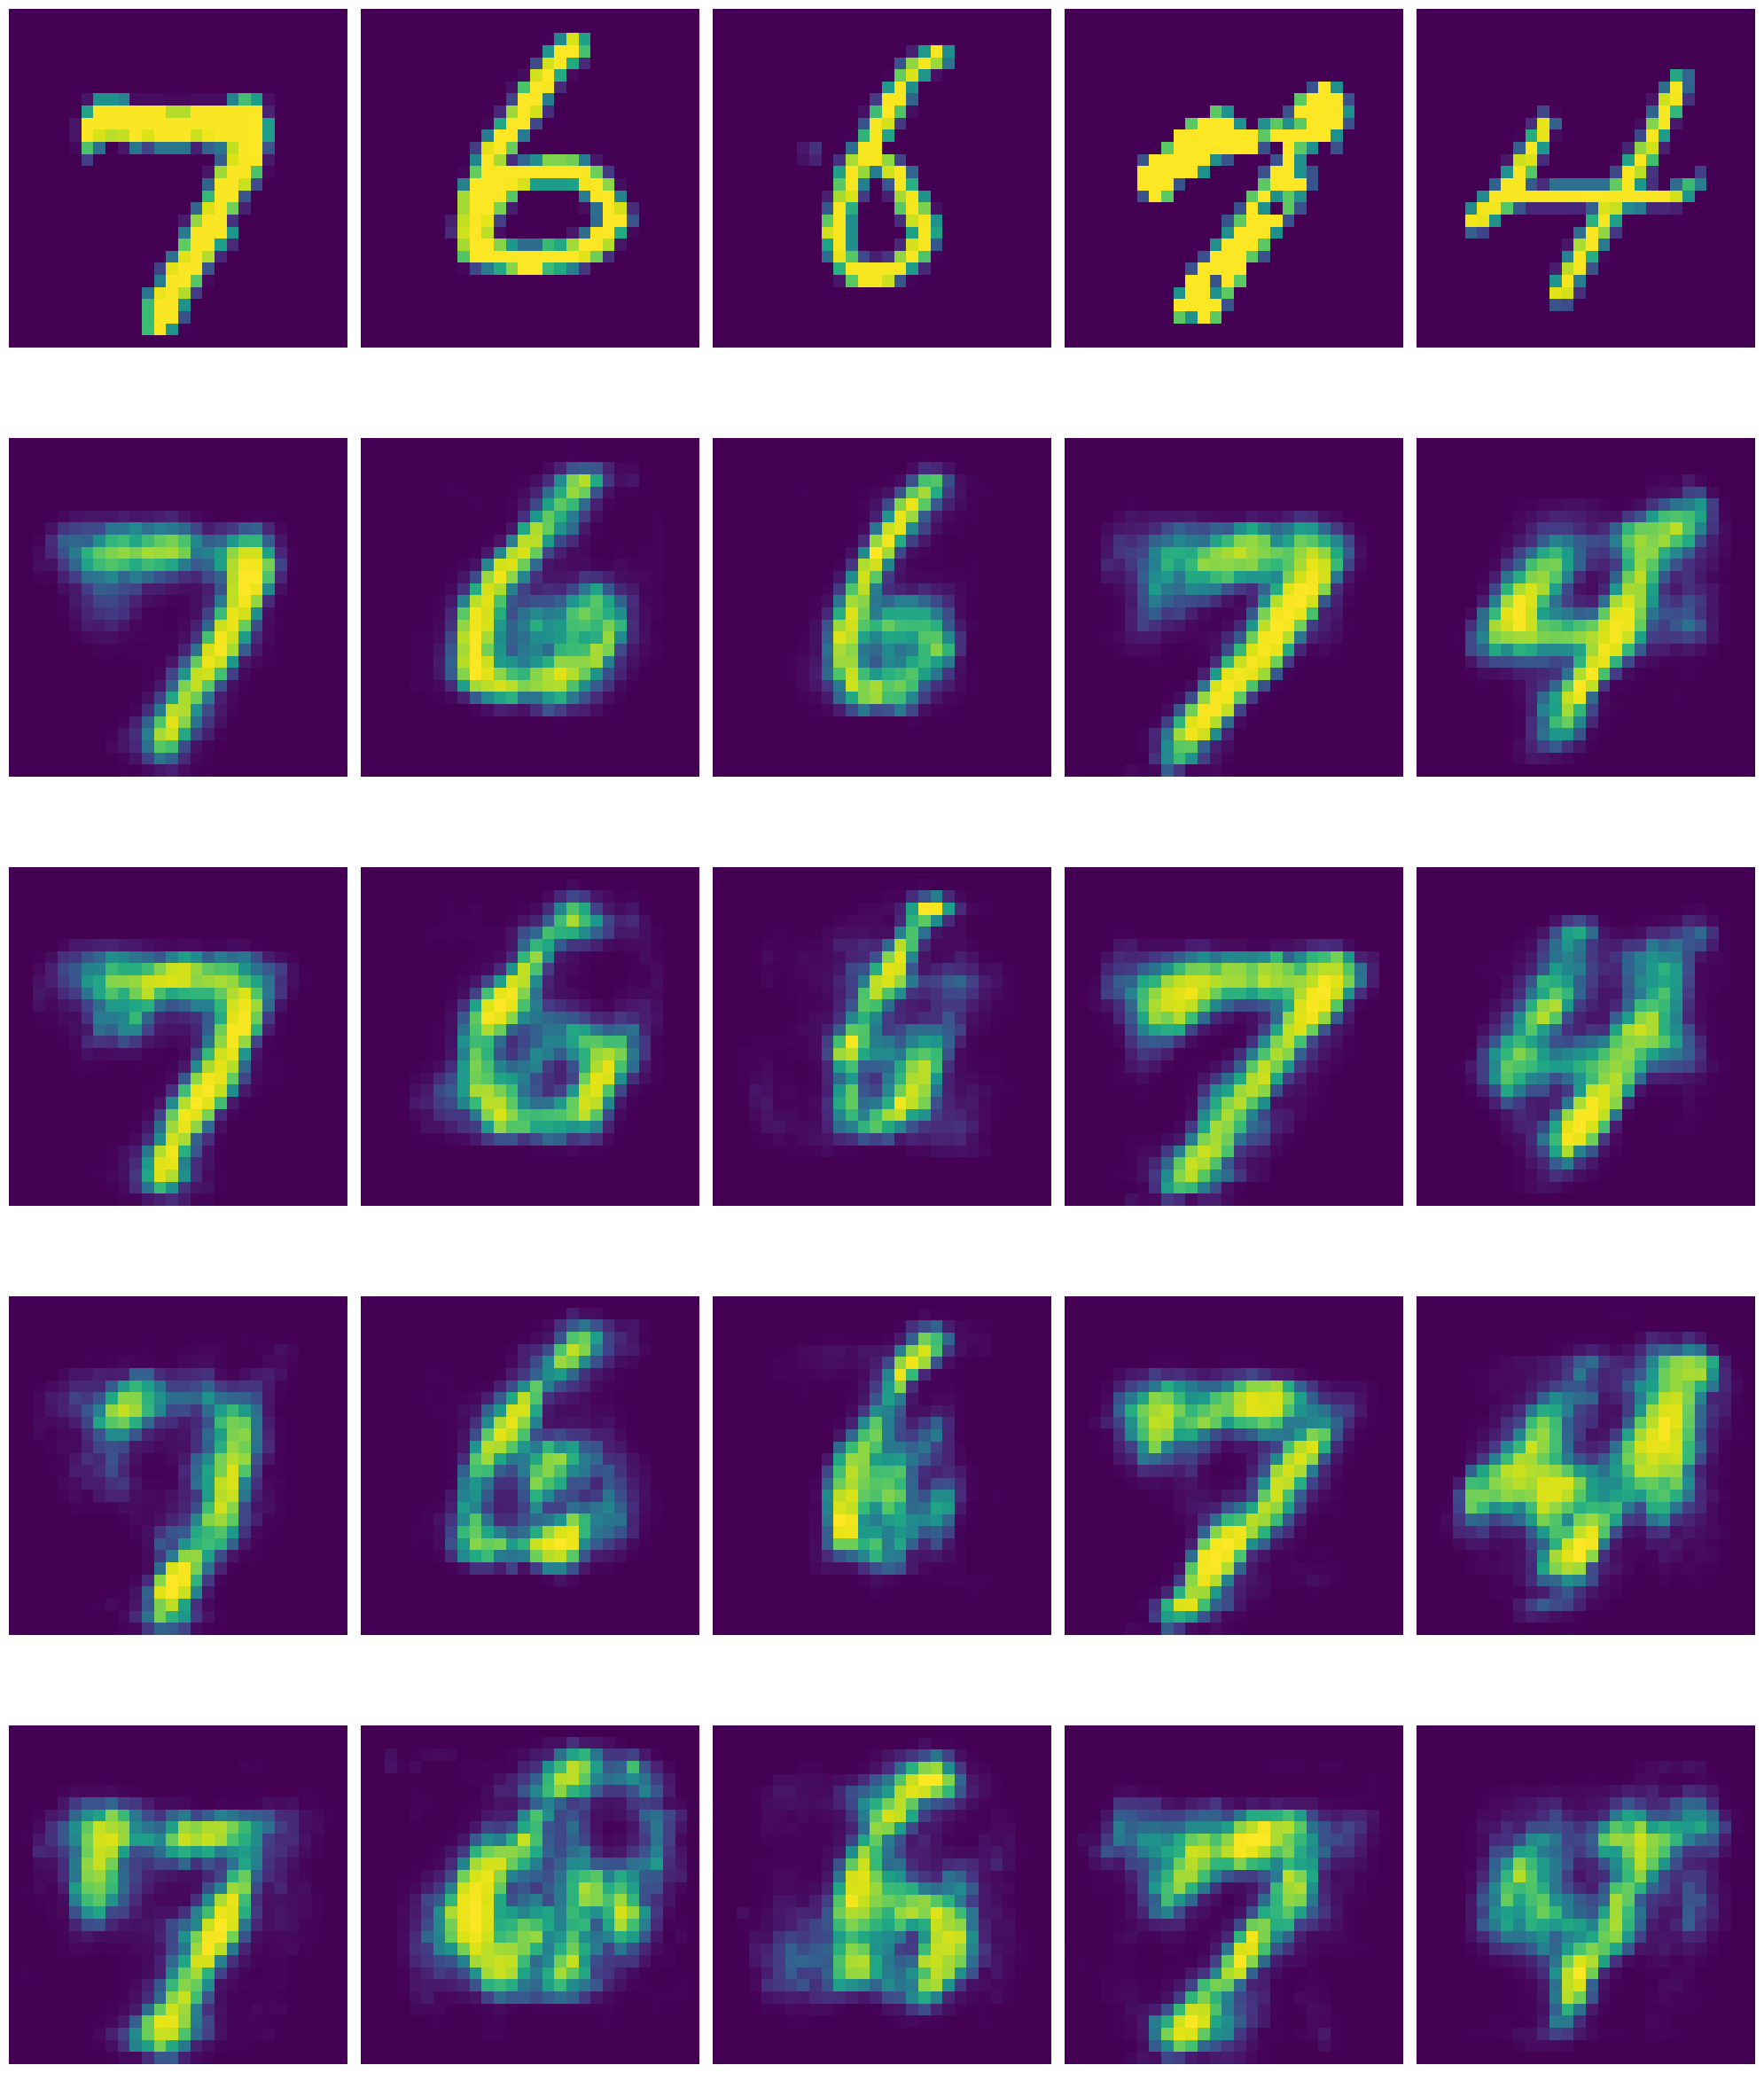

In [26]:
import matplotlib.pyplot as plt

fig, (axs1, axs2, axs3, axs4, axs5) = plt.subplots(nrows=5, ncols=5, figsize=[20, 25])

manager.model.to('cpu')
manager.model.eval()

with torch.no_grad():
    for x, y in manager.train_dataloader:
        z = manager.model.get_submodule('encoder')(x[:5])
        h = manager.model.get_submodule('decoder').step_1(z)
        d = torch.distributions.Bernoulli(0.9)
        h_prime = h * d.sample(h.shape)
        x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
            
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.8)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.7)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs4, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')

            d = torch.distributions.Bernoulli(0.6)
            h_prime = h * d.sample(h.shape)
            x_hats = manager.model.get_submodule('decoder').step_2(h_prime)
        for ax, img in zip(axs5, x_hats):
            ax.imshow(img.view([28, 28]))
            ax.axis('off')
        break
plt.tight_layout()

#### 중간 차원을 늘리면 디테일이 보존될 가능성이 높아질까?
- pca가 가장 공분산이 큰 특징 벡터를 배우는 것처럼, 오토인코더 또한 여러 개의 잠재 차원을 도입하는 것이 그 다음으로 잘 발견되는 (오토인코더의 학습 과정에서 흐르게 되는 학습 경로에 있는) 특징을 보존하게 된다.

In [43]:
def show_images(manager):
    fig, (axs1, axs2, axs3, axs4) = plt.subplots(nrows=4, ncols=5, figsize=[20, 16])

    manager.model.to('cpu')
    manager.model.eval()

    x = manager.training_data[10000:]

    with torch.no_grad():
        x_hats = manager.model(x[:10])
    for ax, img in zip(axs1, x[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs2, x[5:10]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs3, x_hats[:5]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
    for ax, img in zip(axs4, x_hats[5:10]):
        ax.imshow(img.view([28, 28]))
        ax.axis('off')
        
    plt.tight_layout()

In [29]:
latent_dim = 4

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

def calc_loss(model, x, y, F, device):
    z = model.get_submodule("encoder")(x)
    x_hat = model.get_submodule("decoder")(z)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

hist = manager.train(calc_loss, epochs=10)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


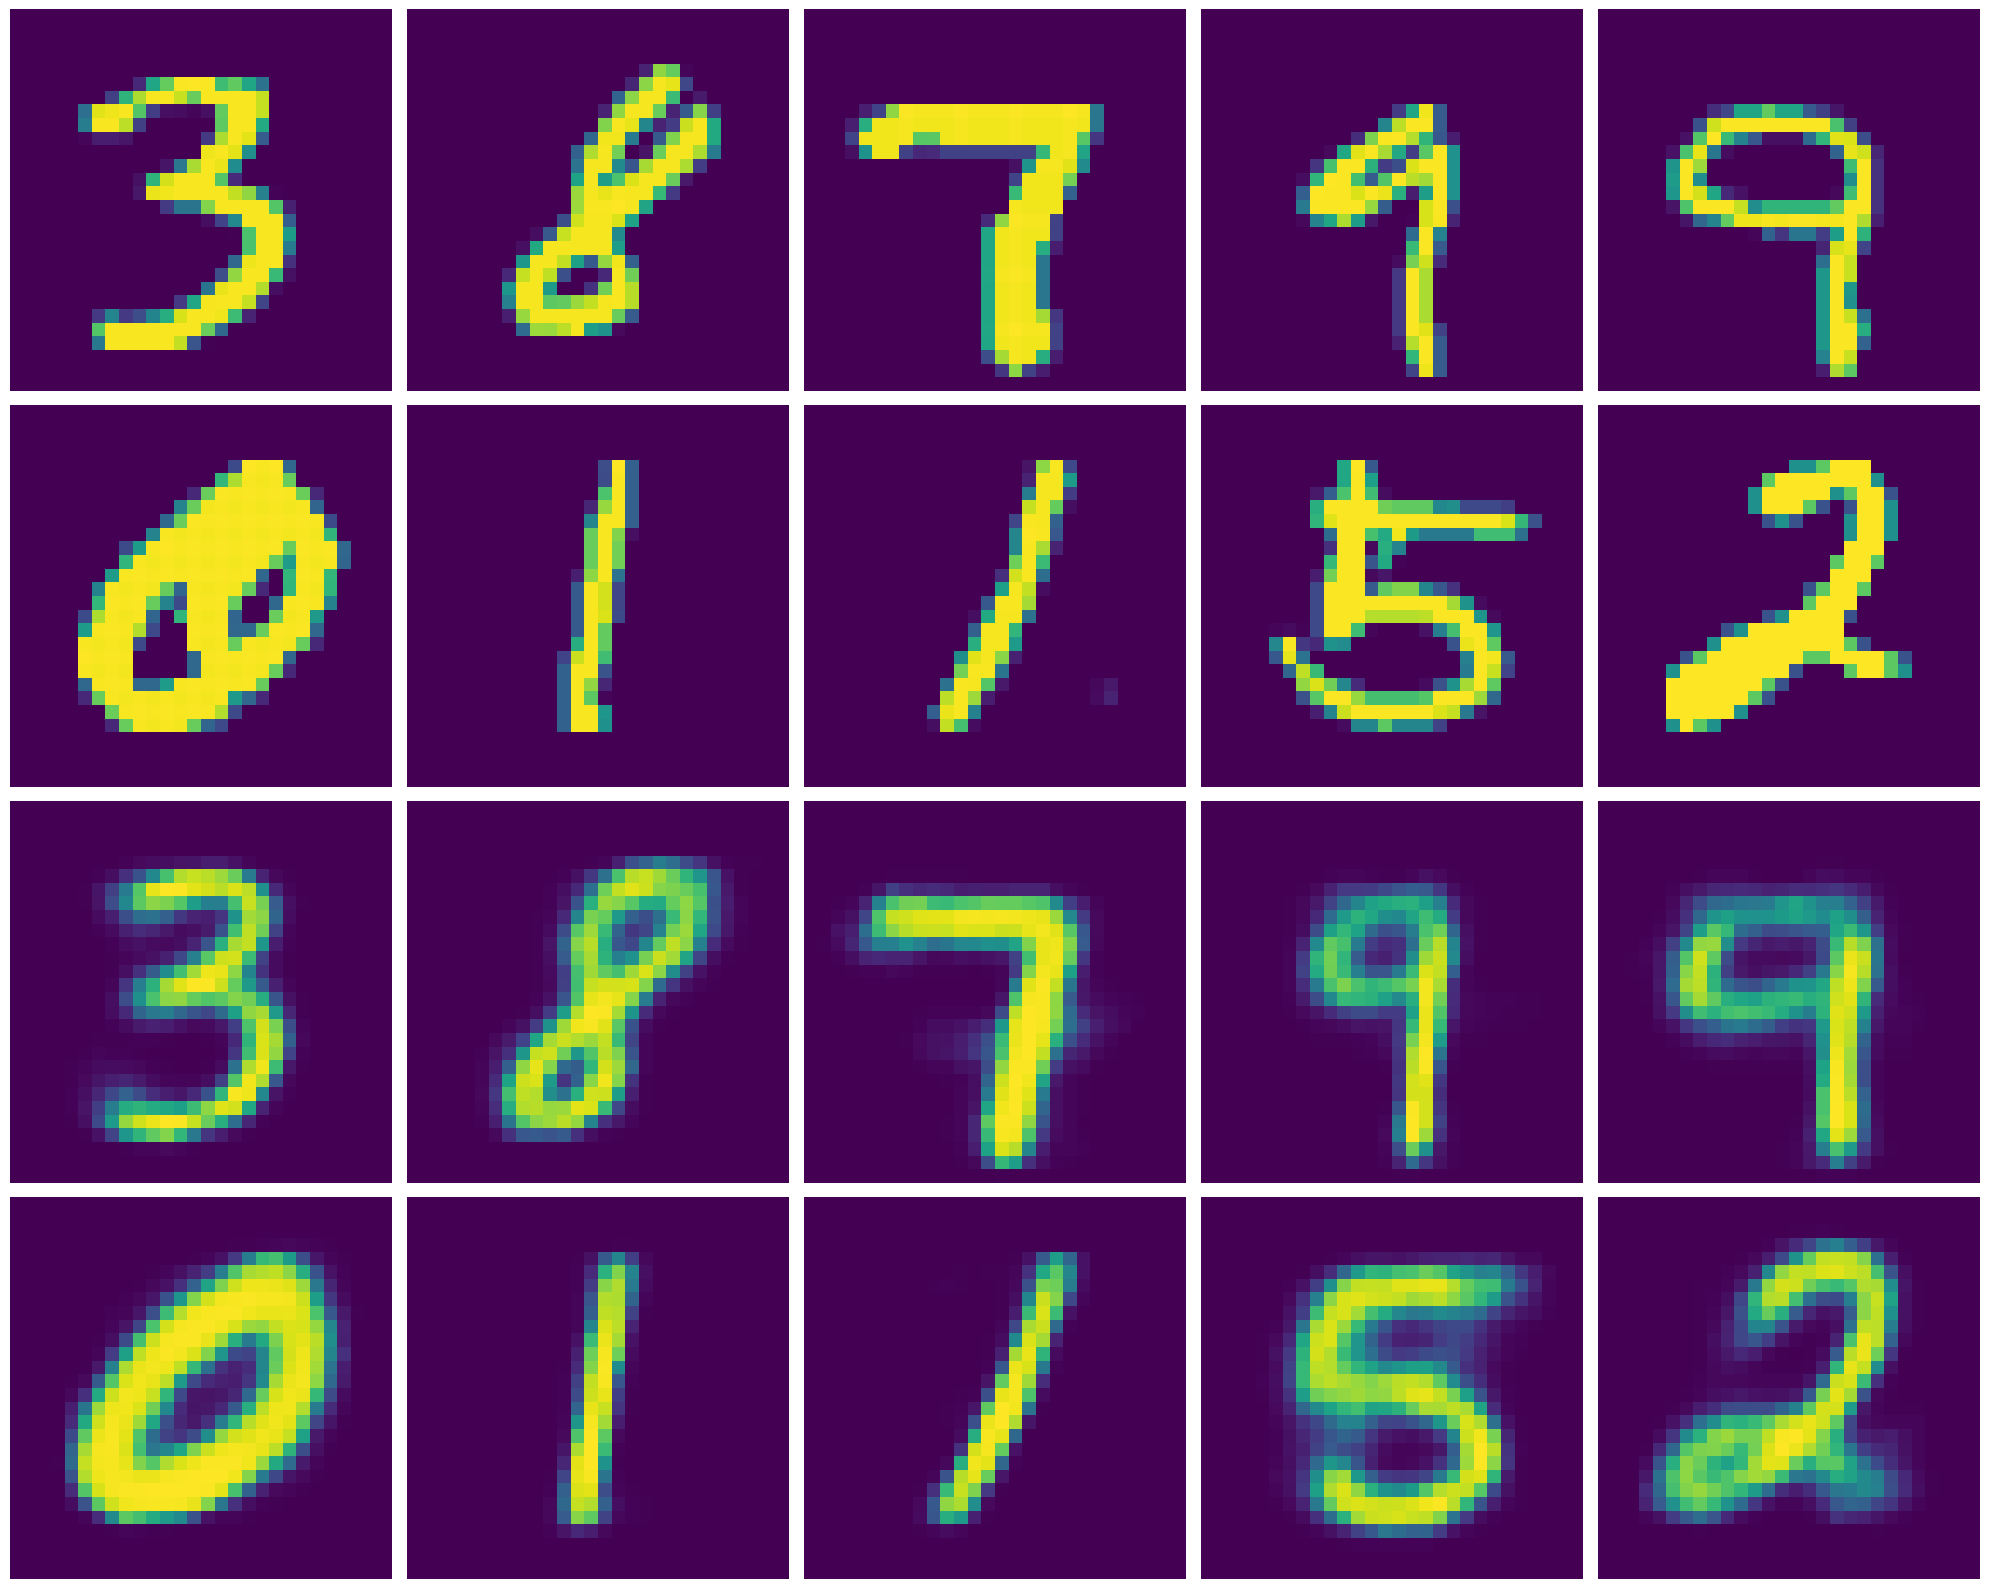

In [44]:
show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


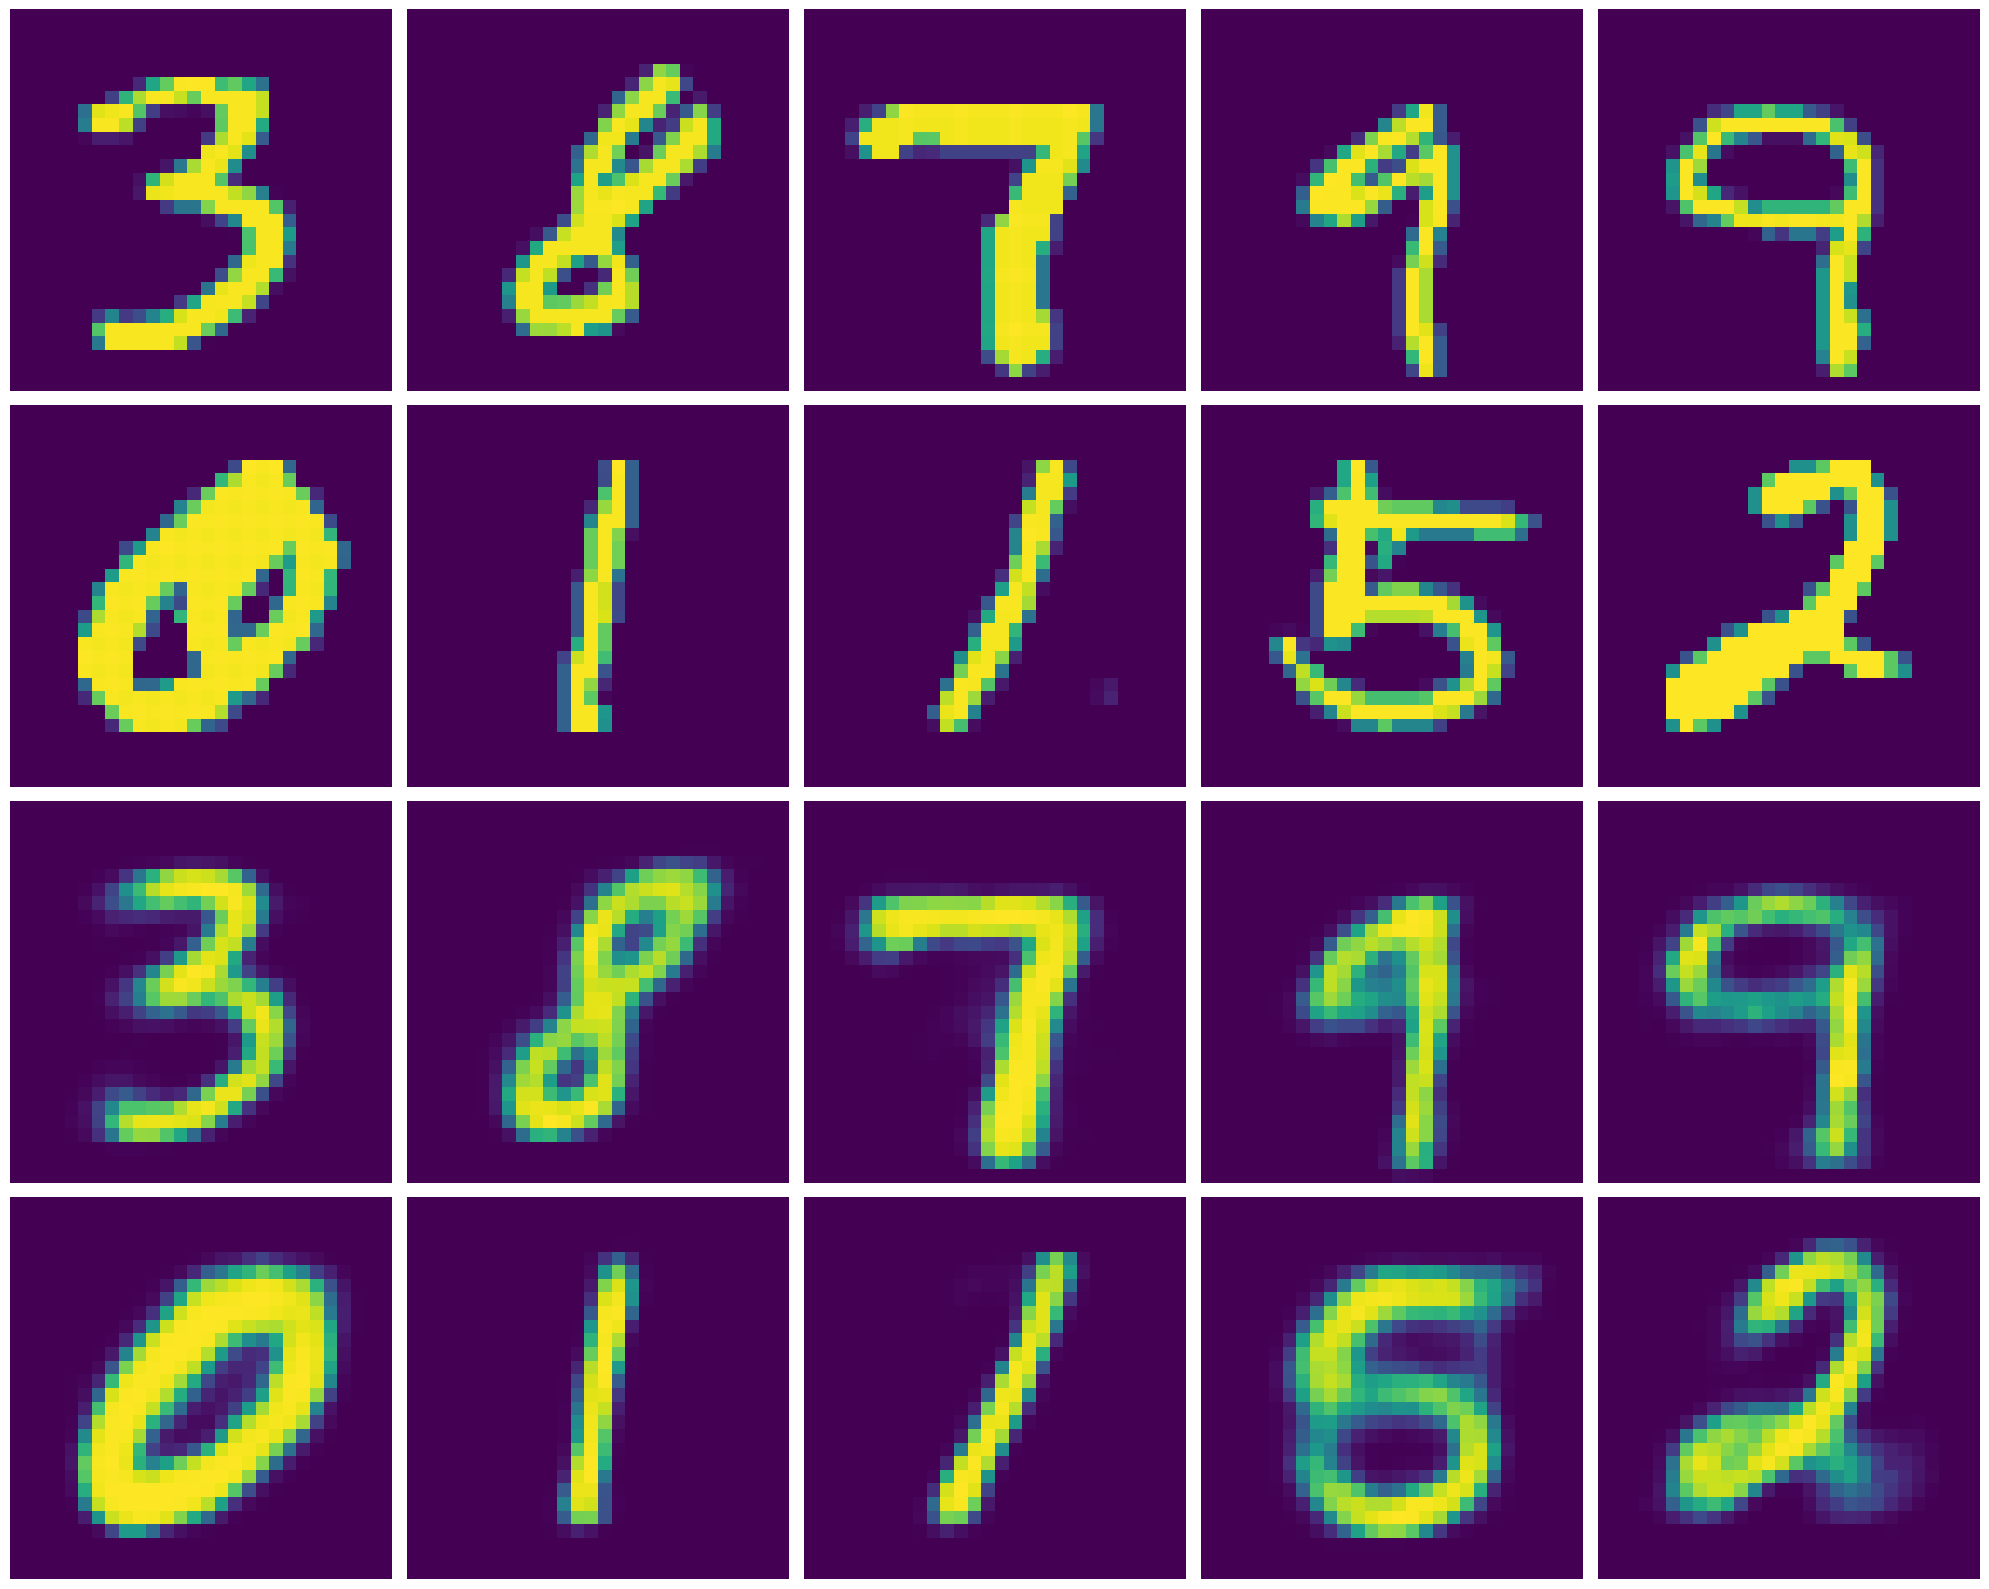

In [46]:
latent_dim = 6

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


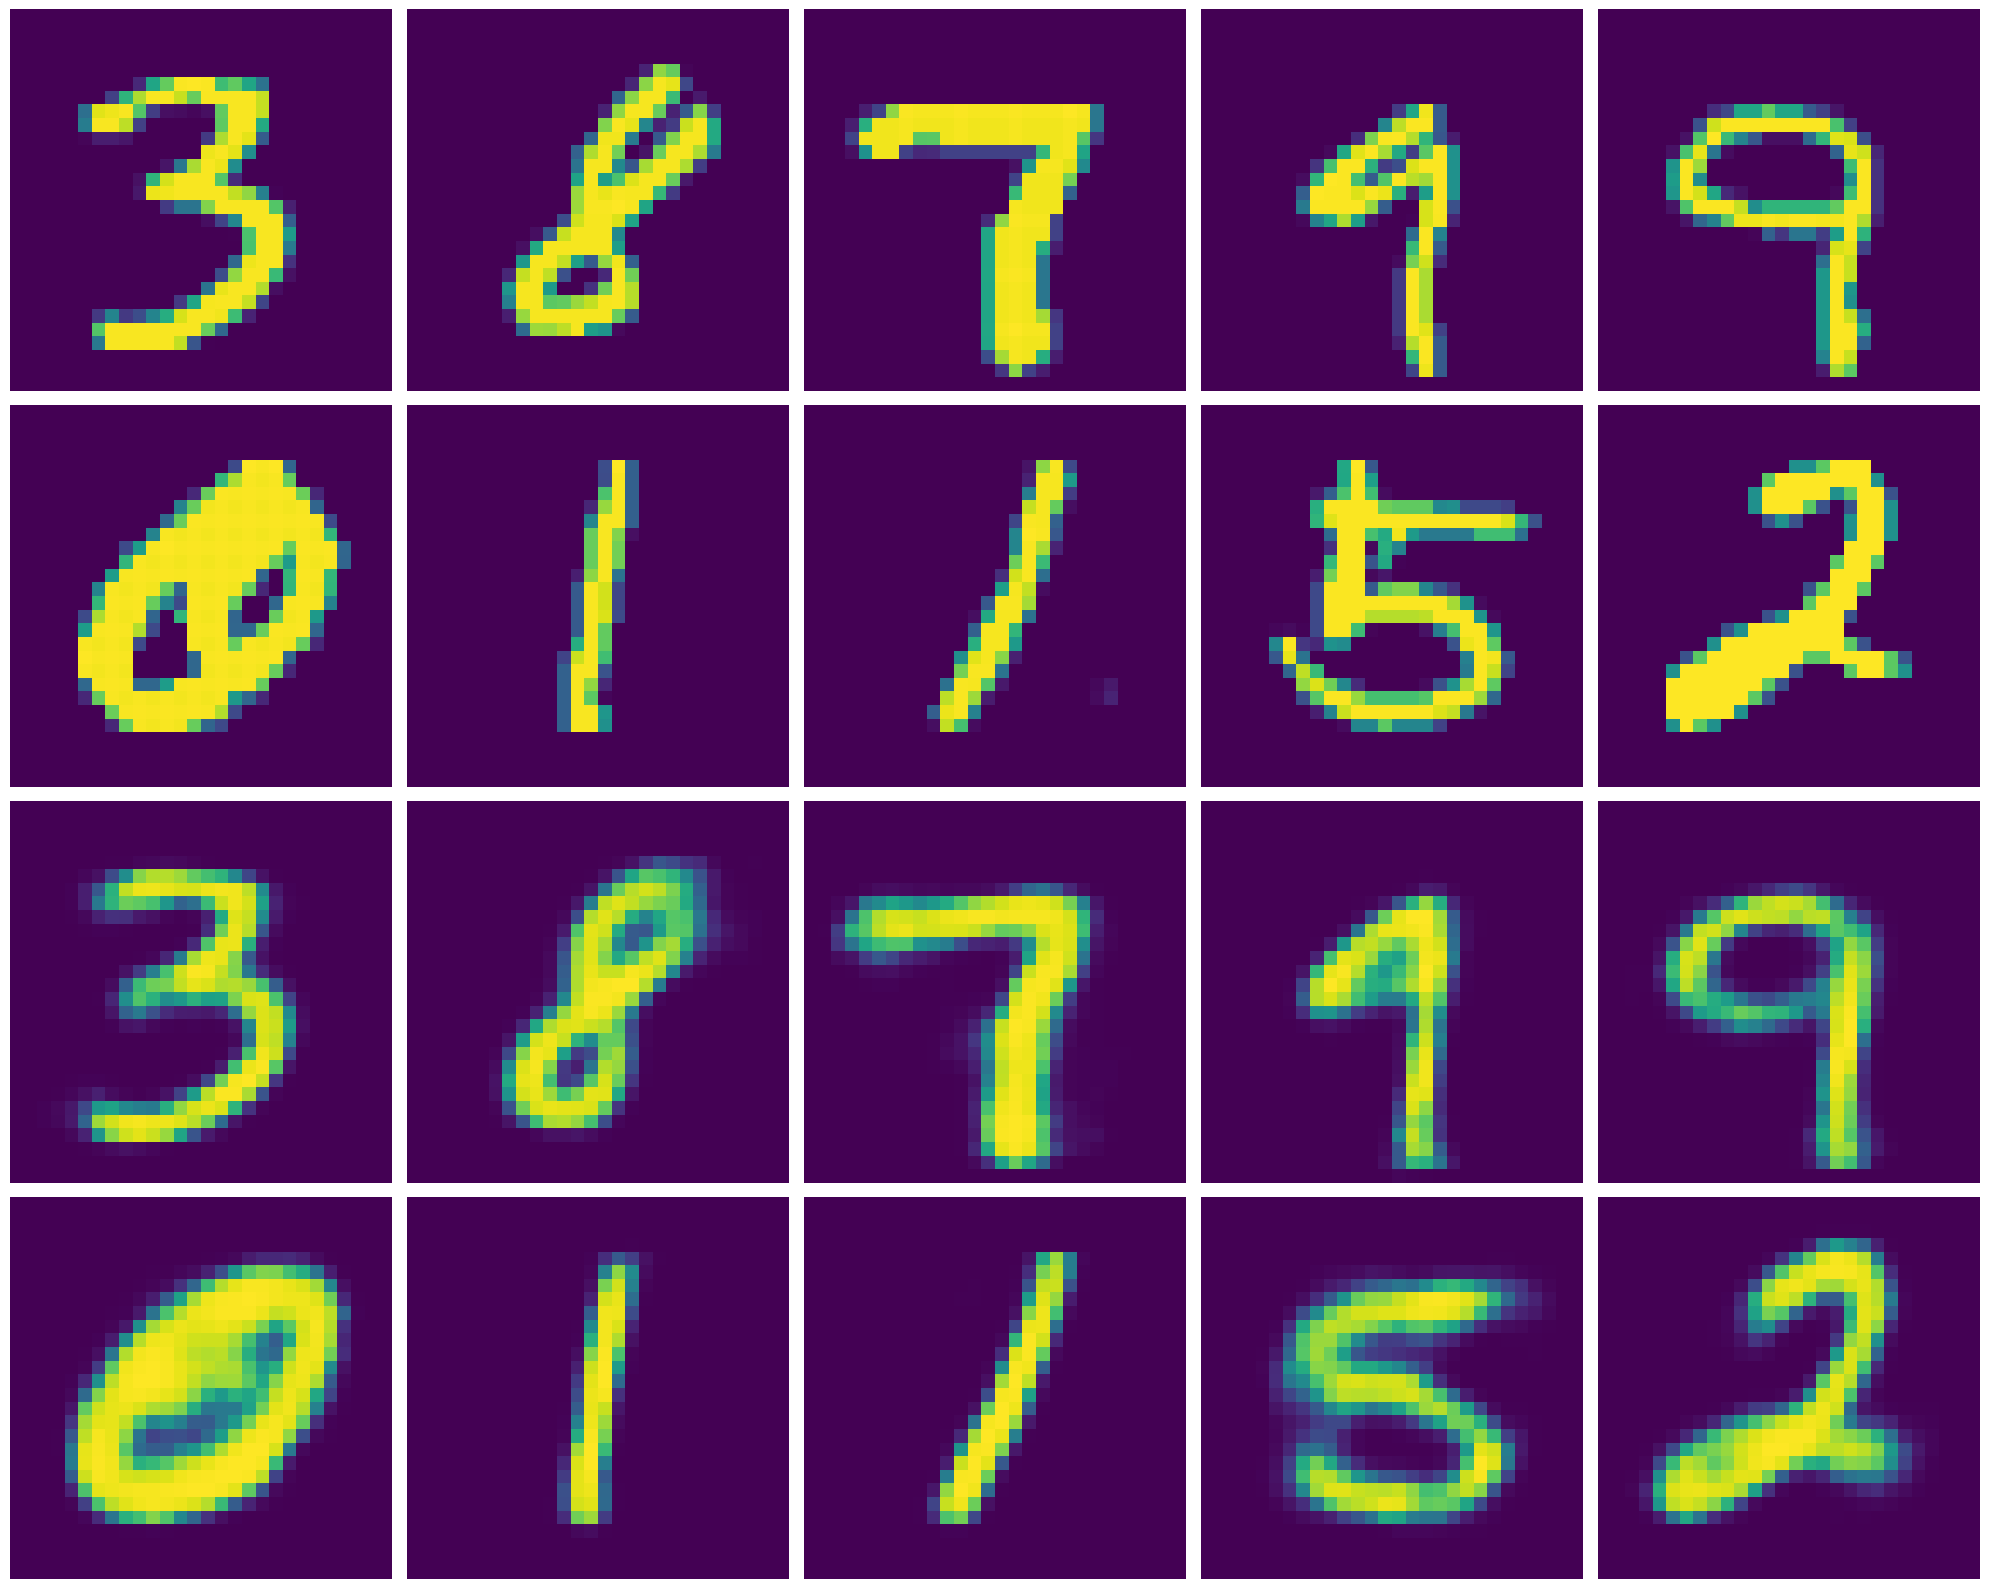

In [47]:
latent_dim = 8

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.76s/it]


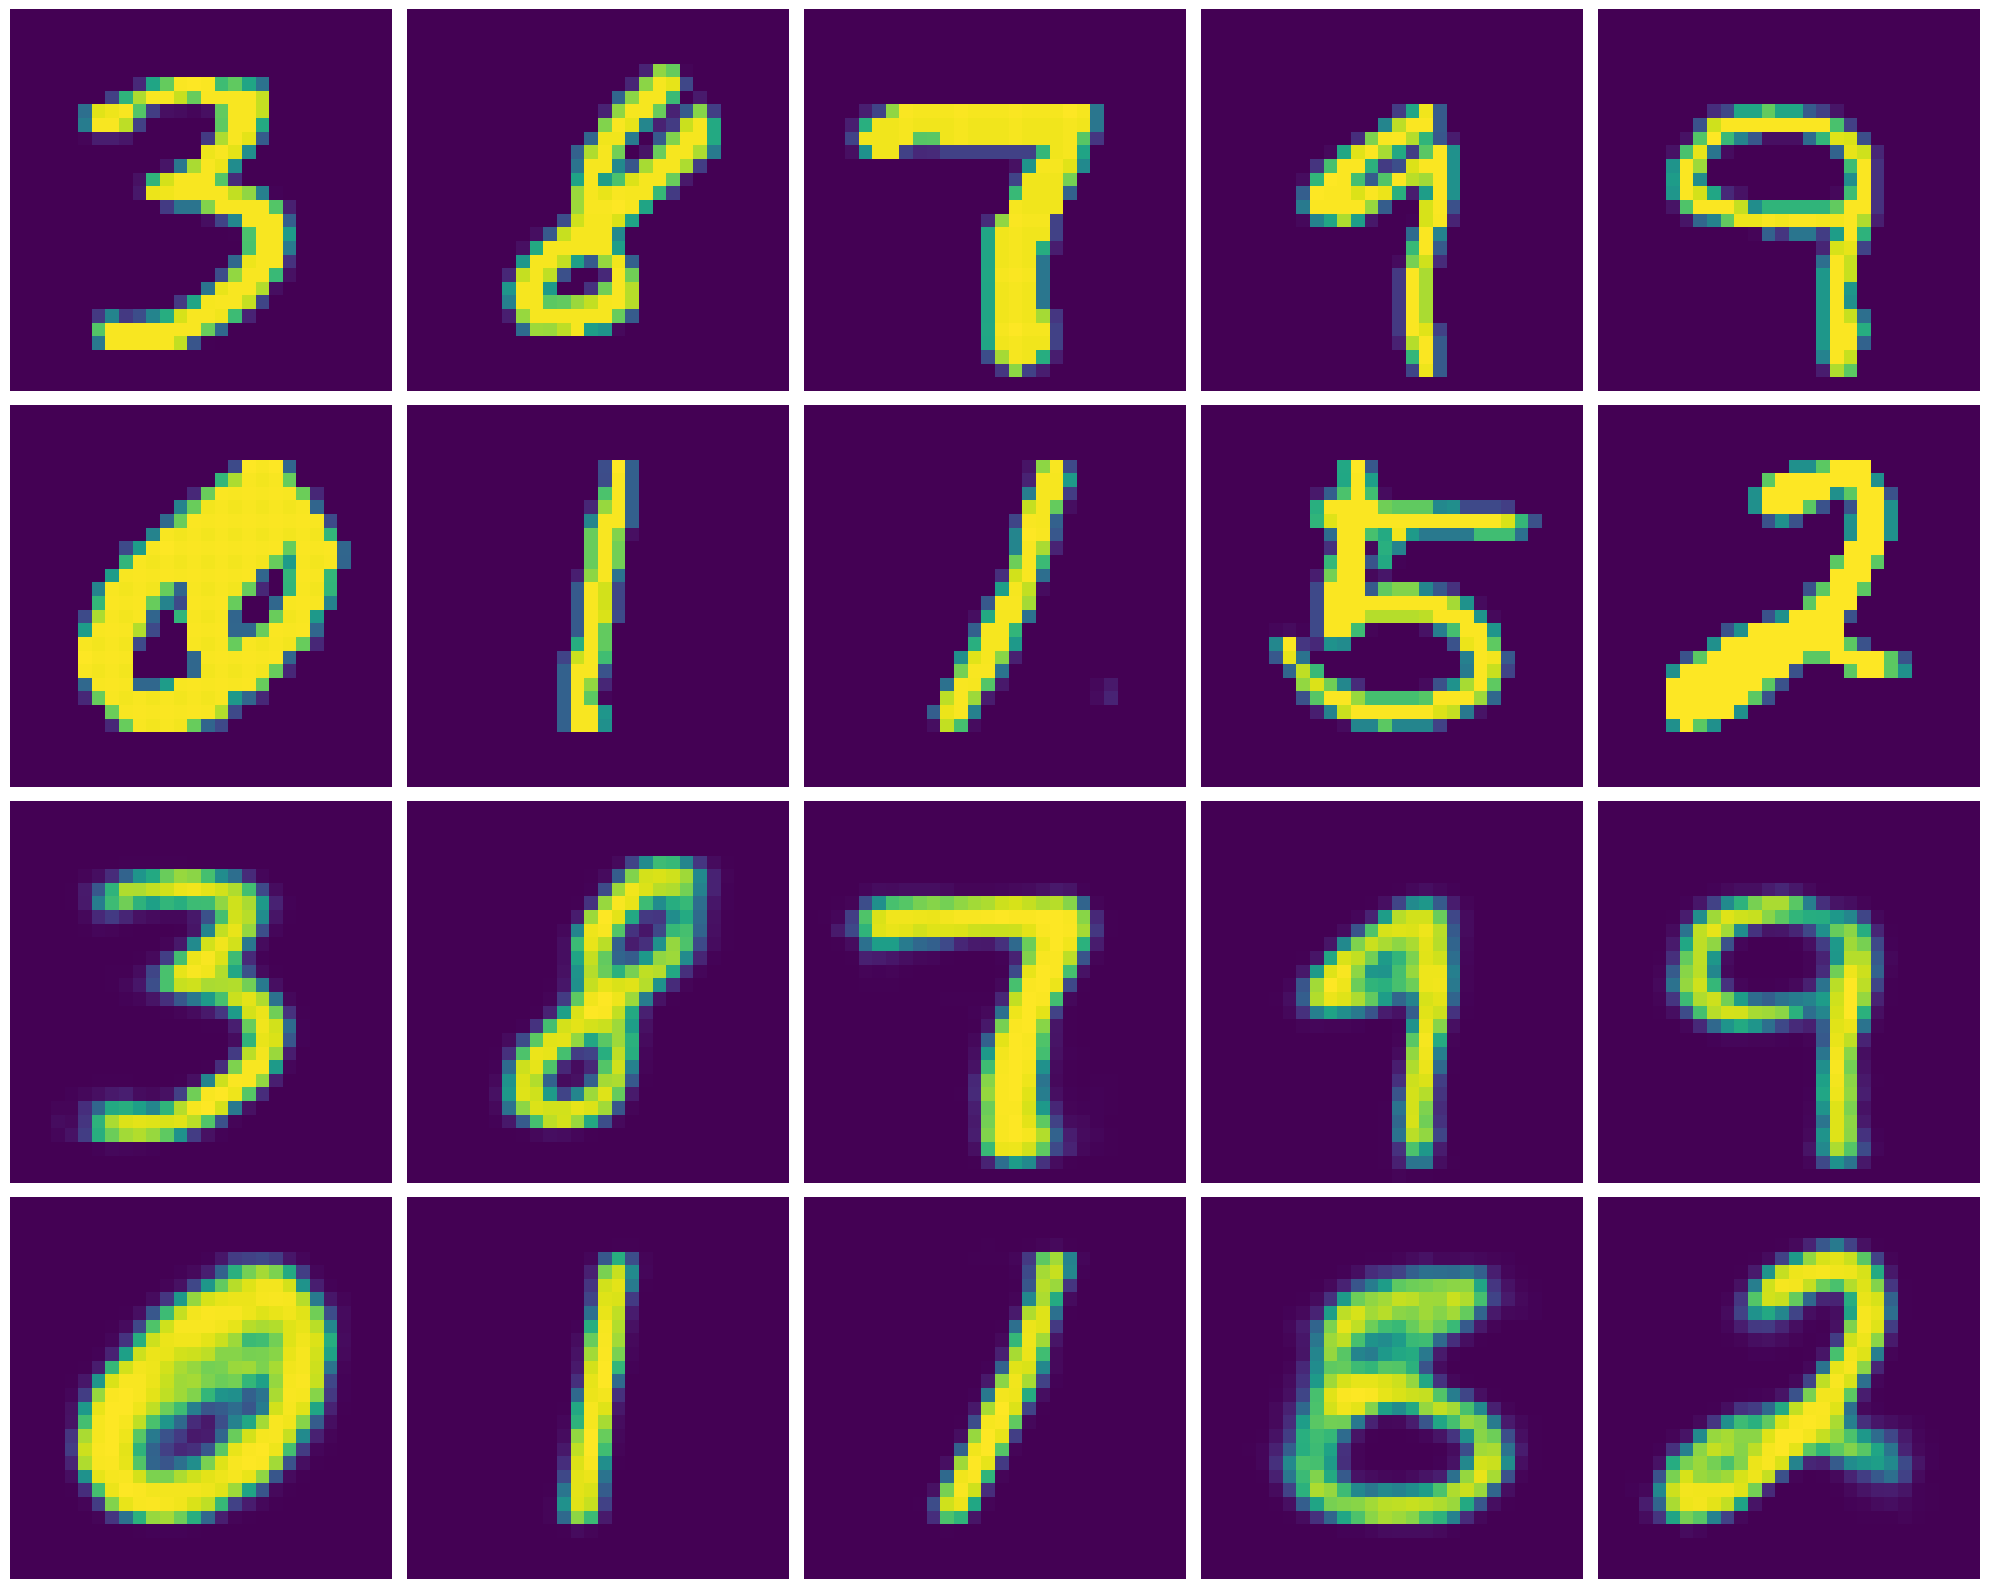

In [48]:
latent_dim = 10

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.80s/it]


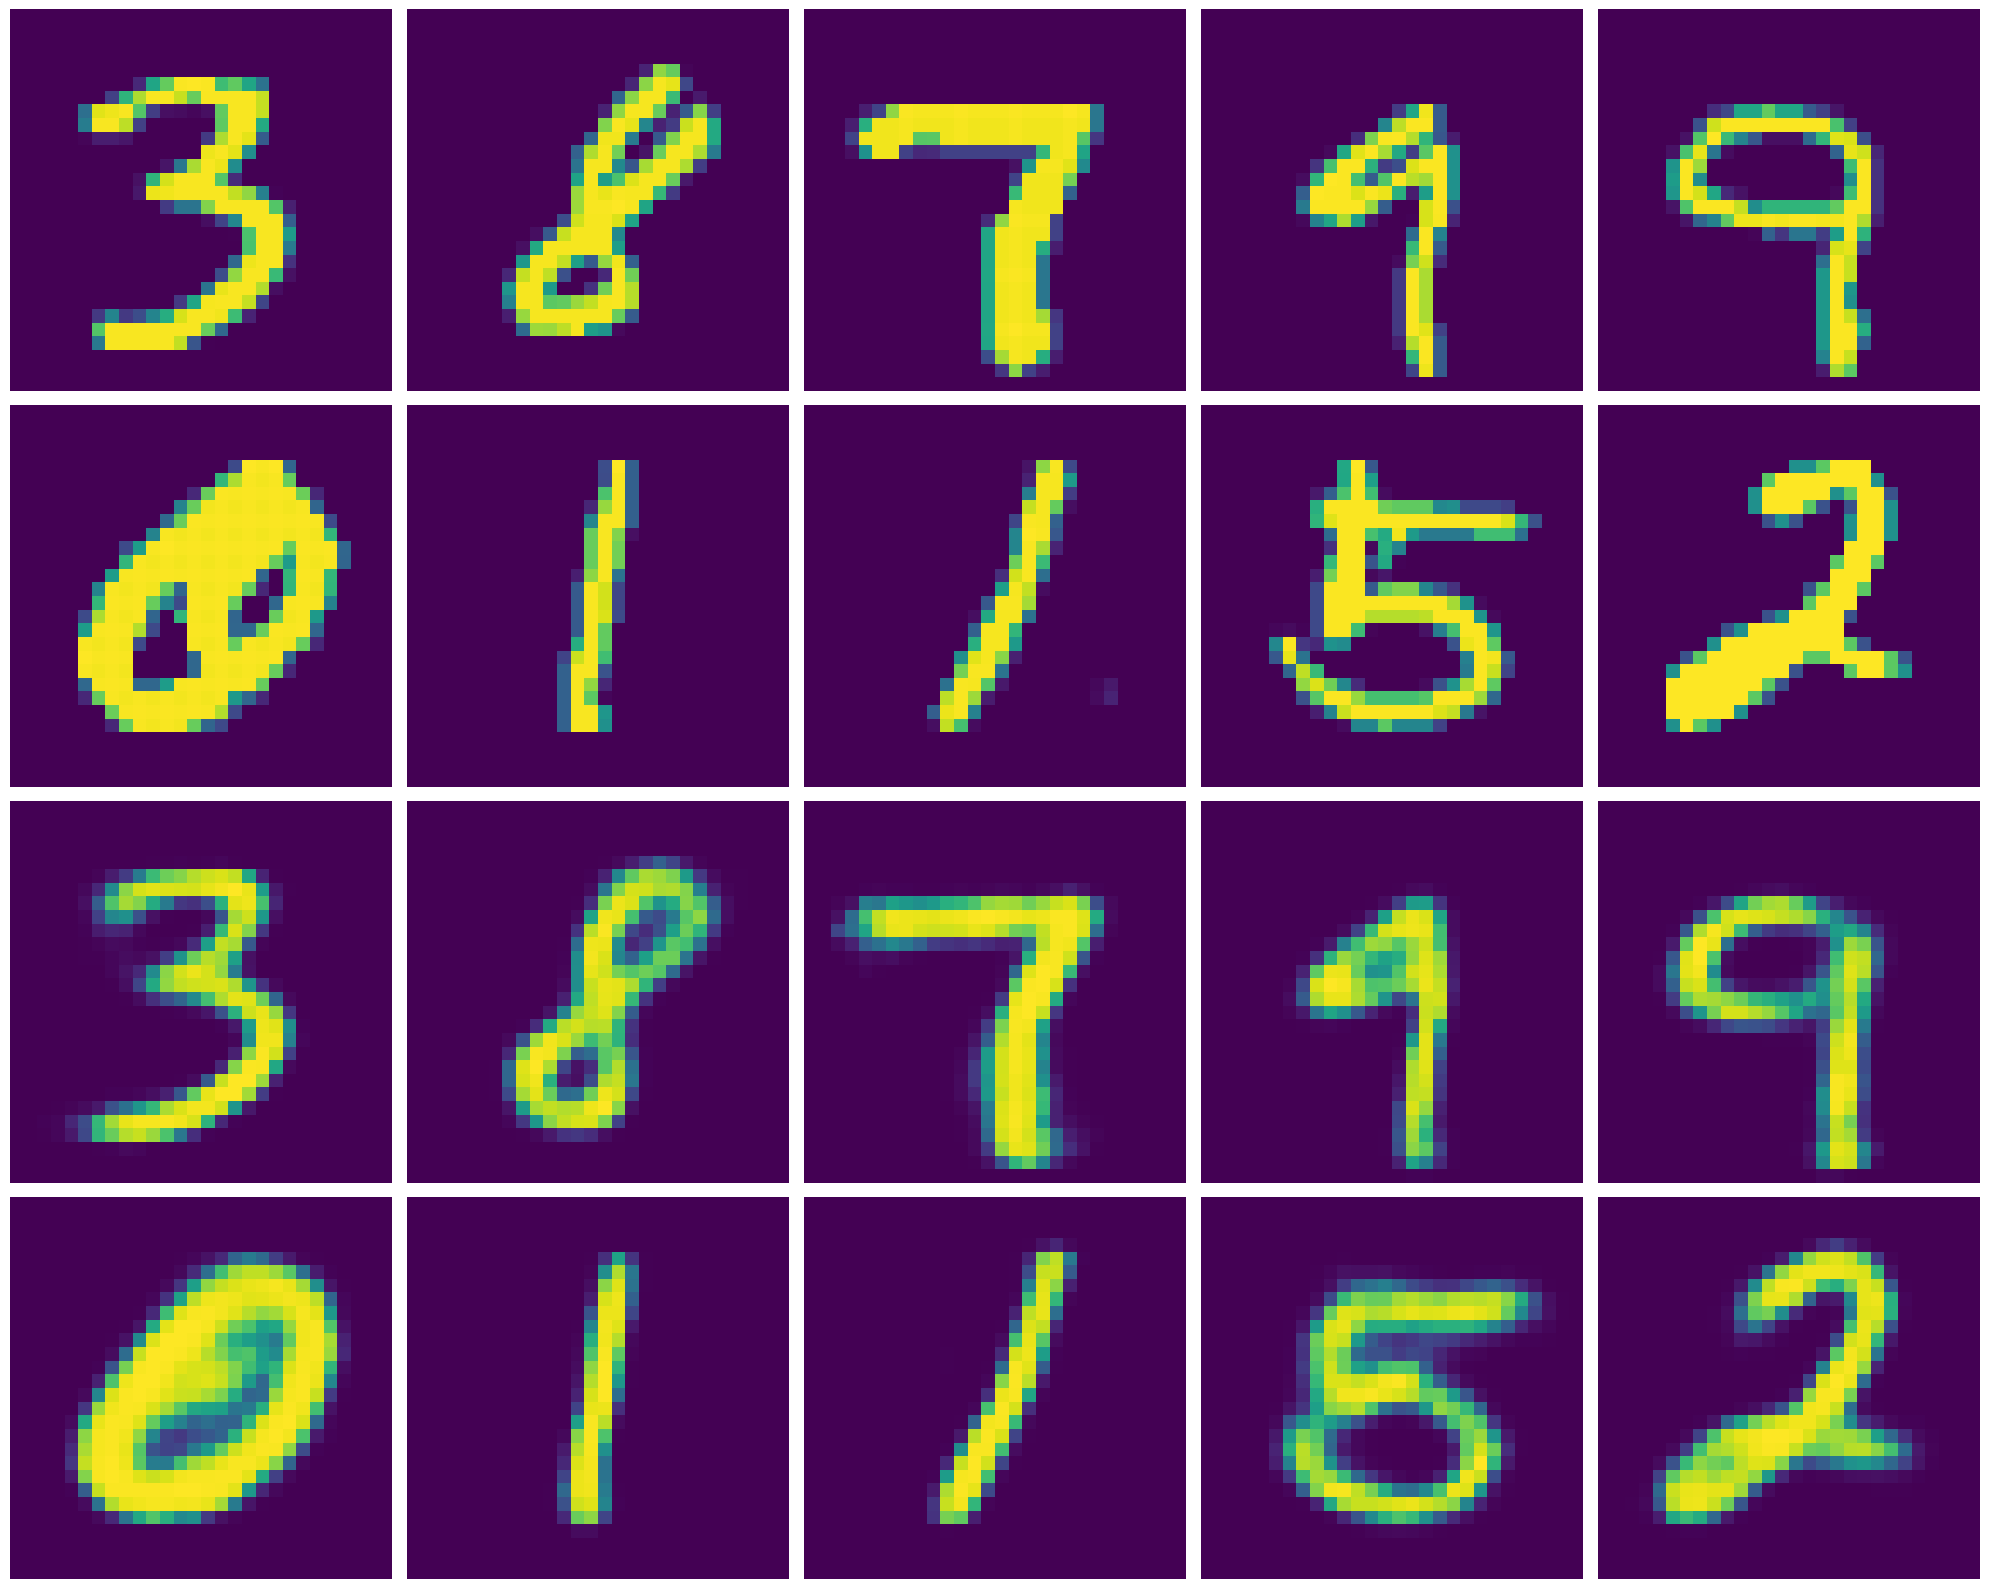

In [49]:
latent_dim = 12

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


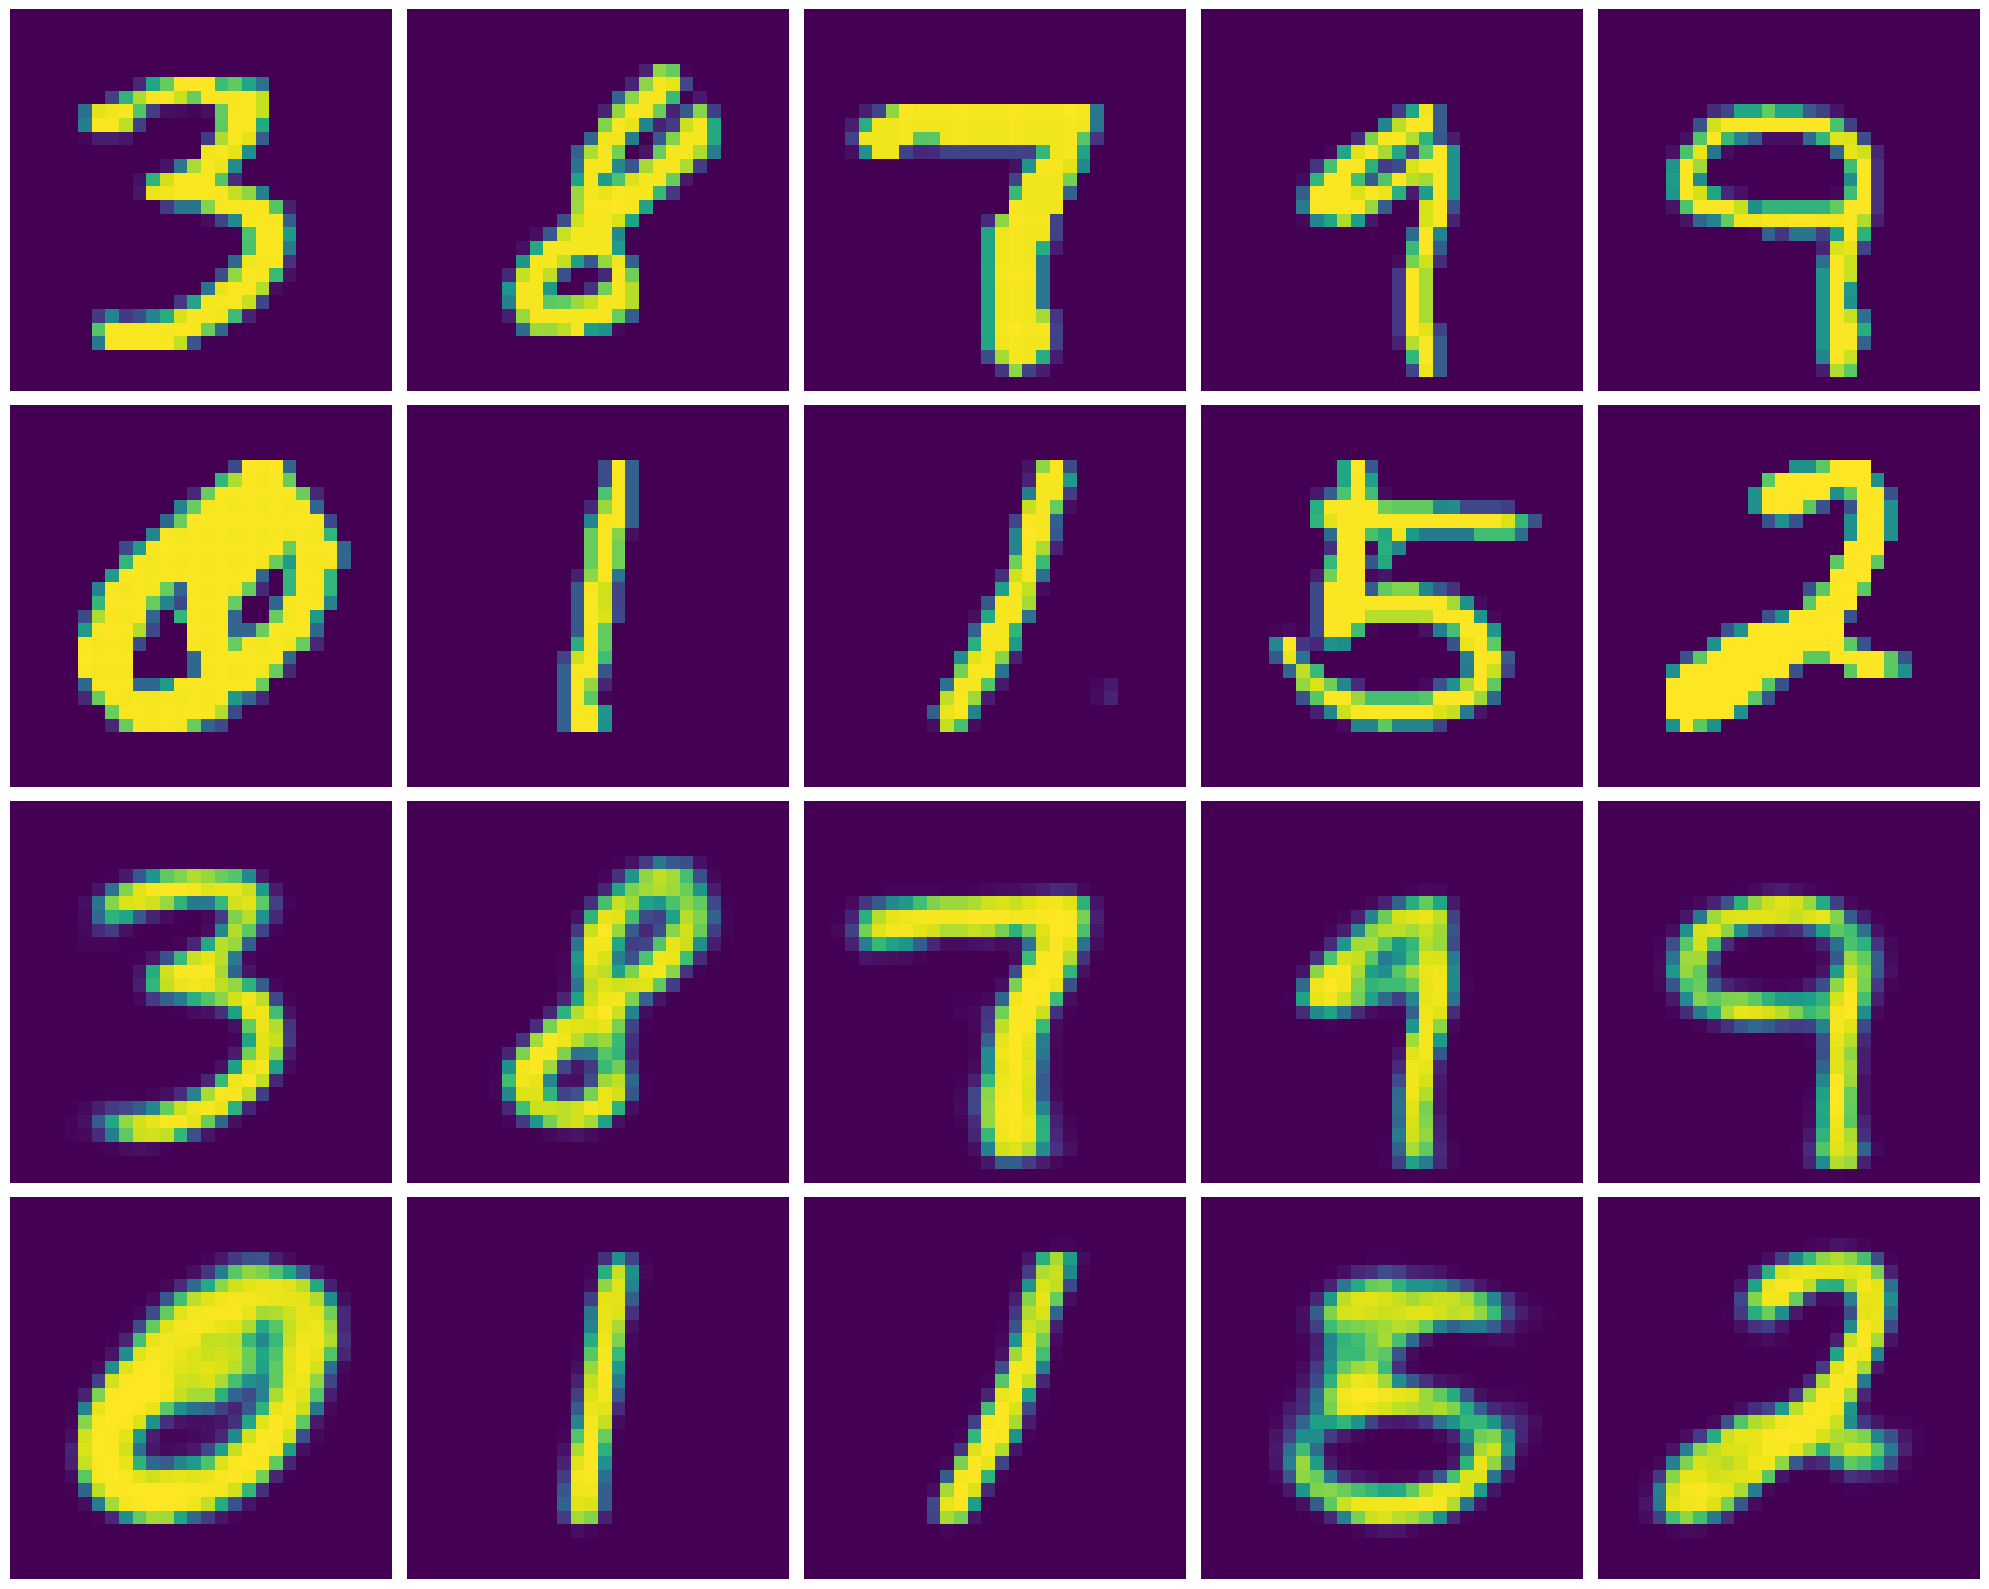

In [50]:
latent_dim = 14

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


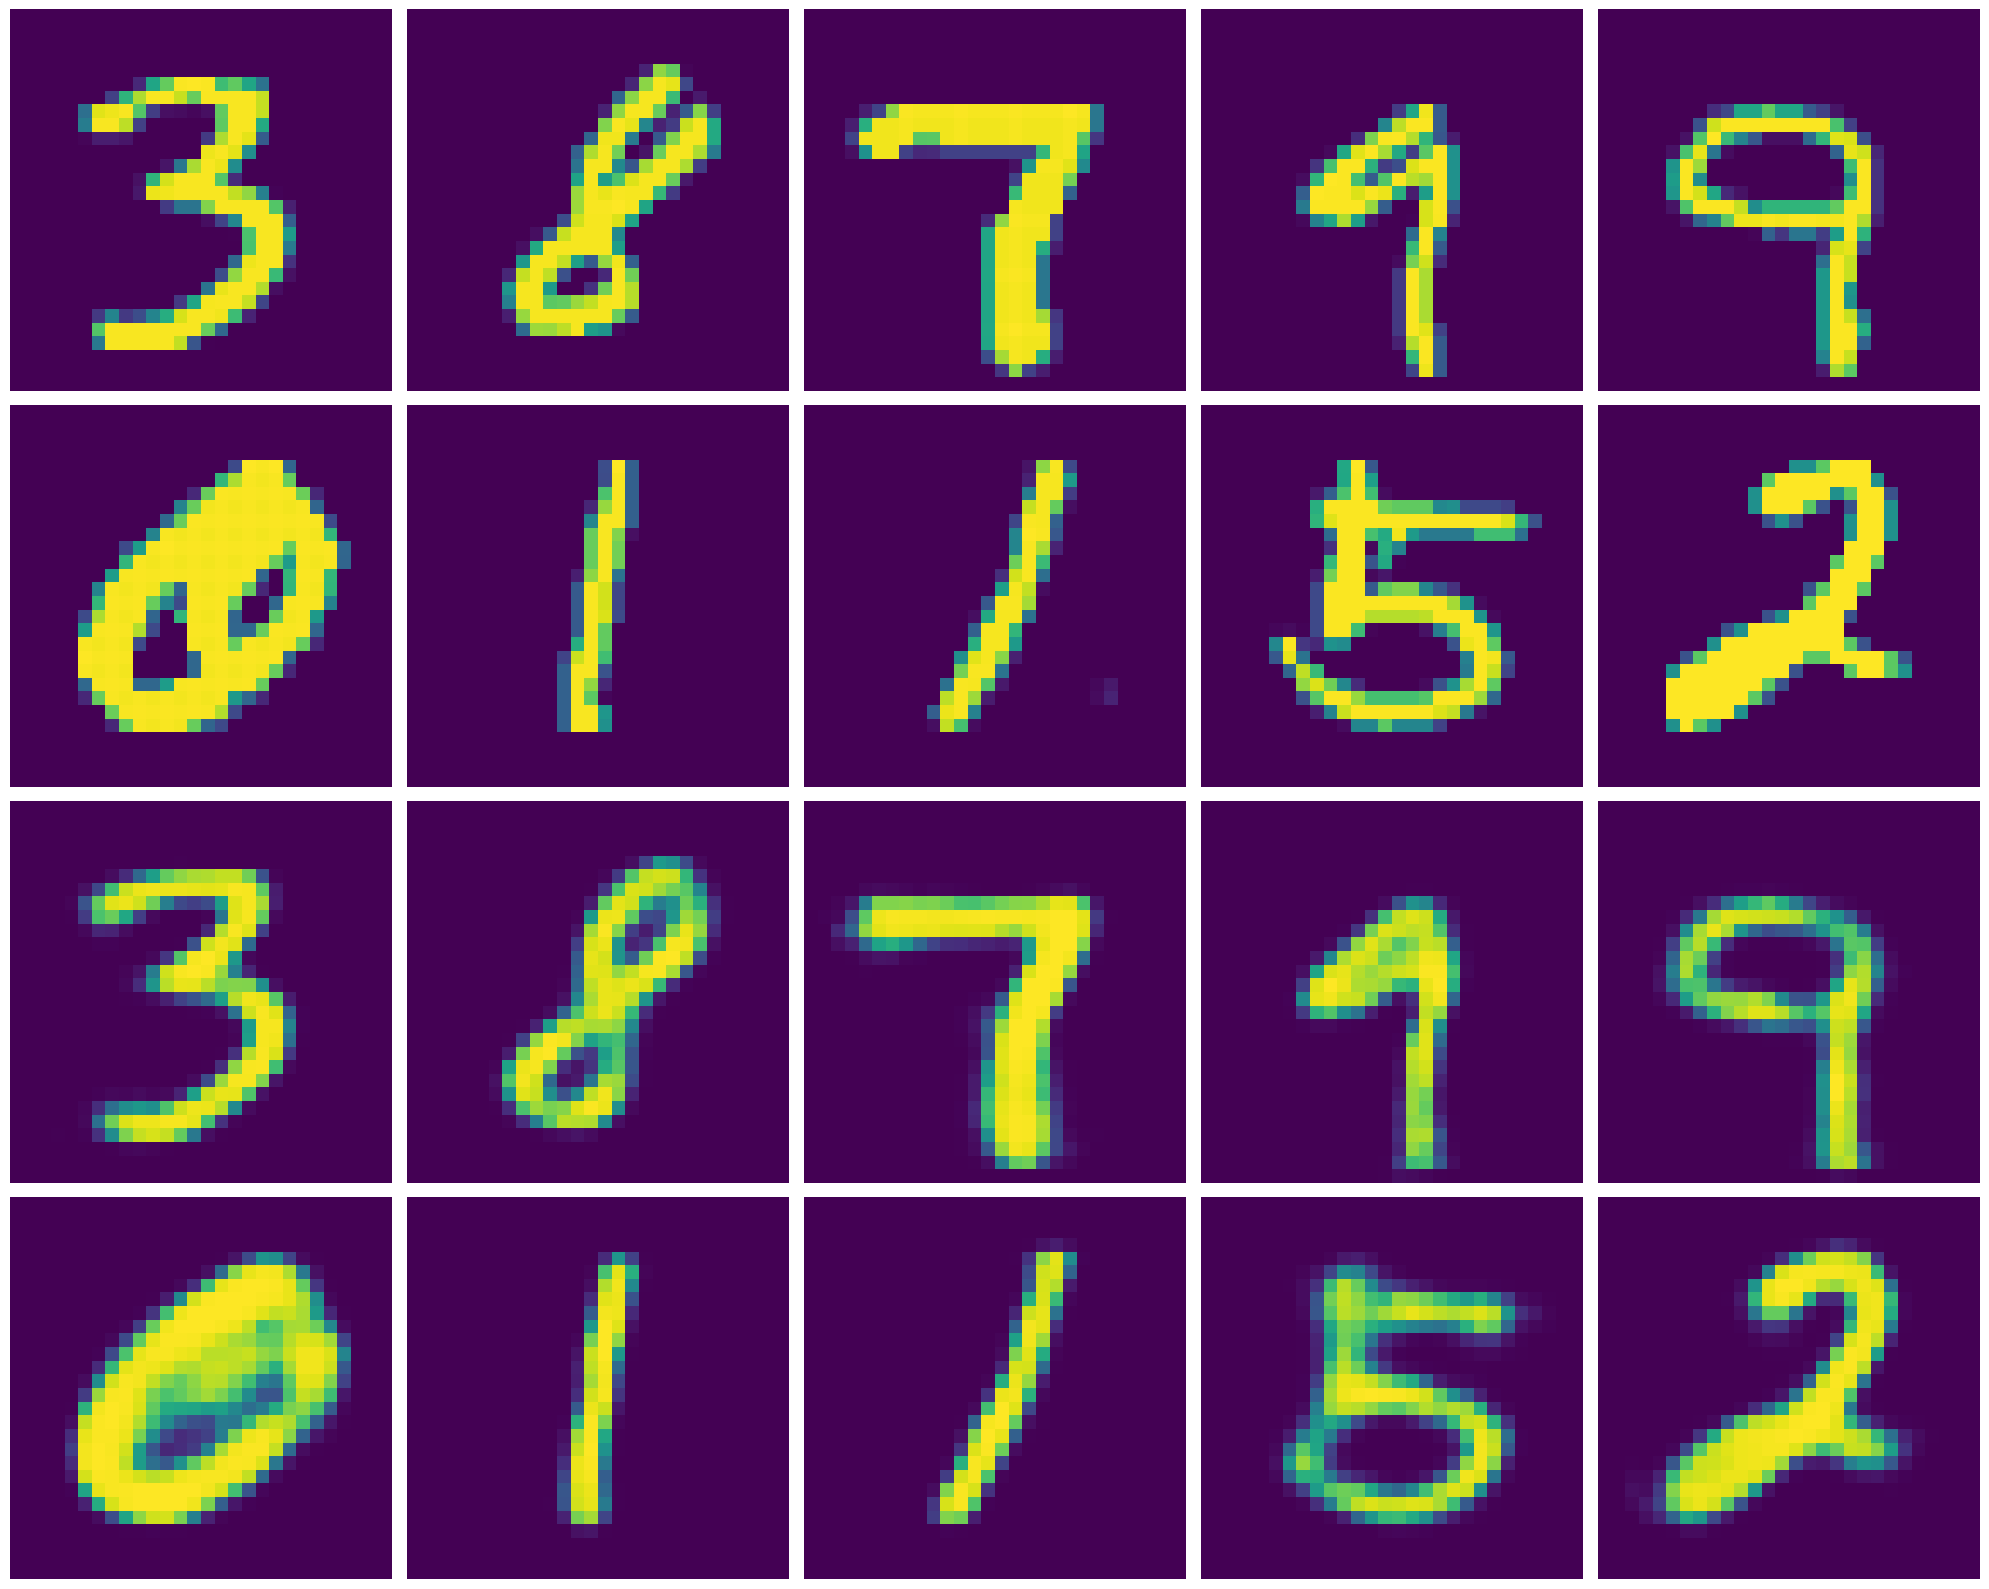

In [51]:
latent_dim = 16

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


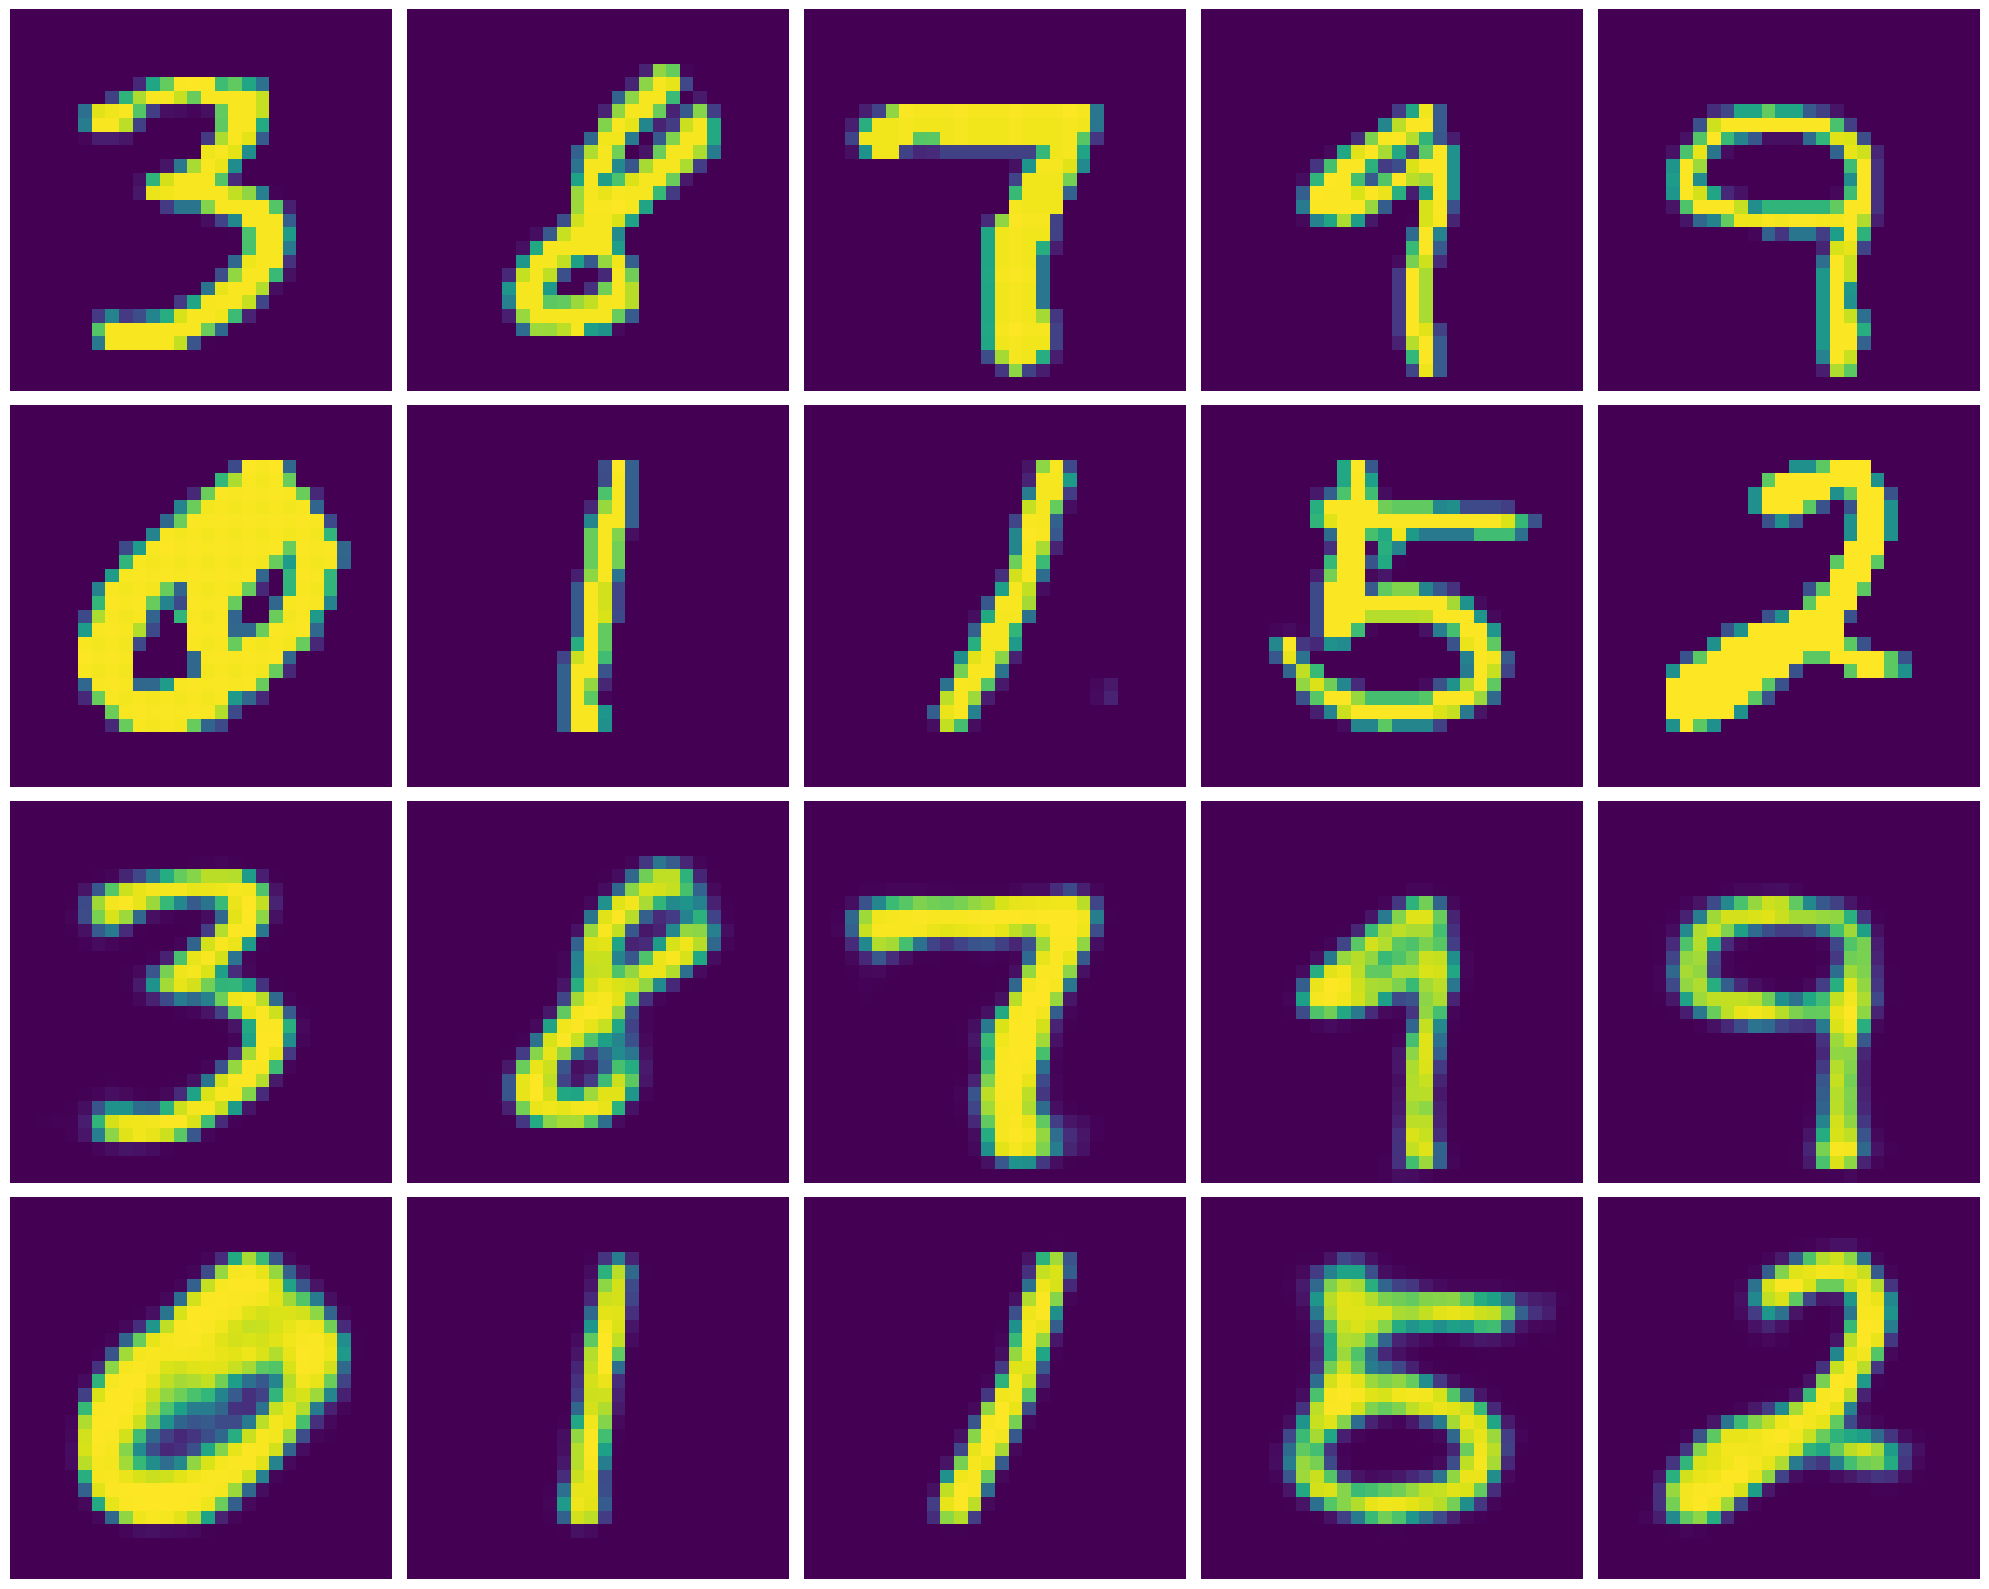

In [52]:
latent_dim = 18

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

Now, it is working on cuda:0.


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


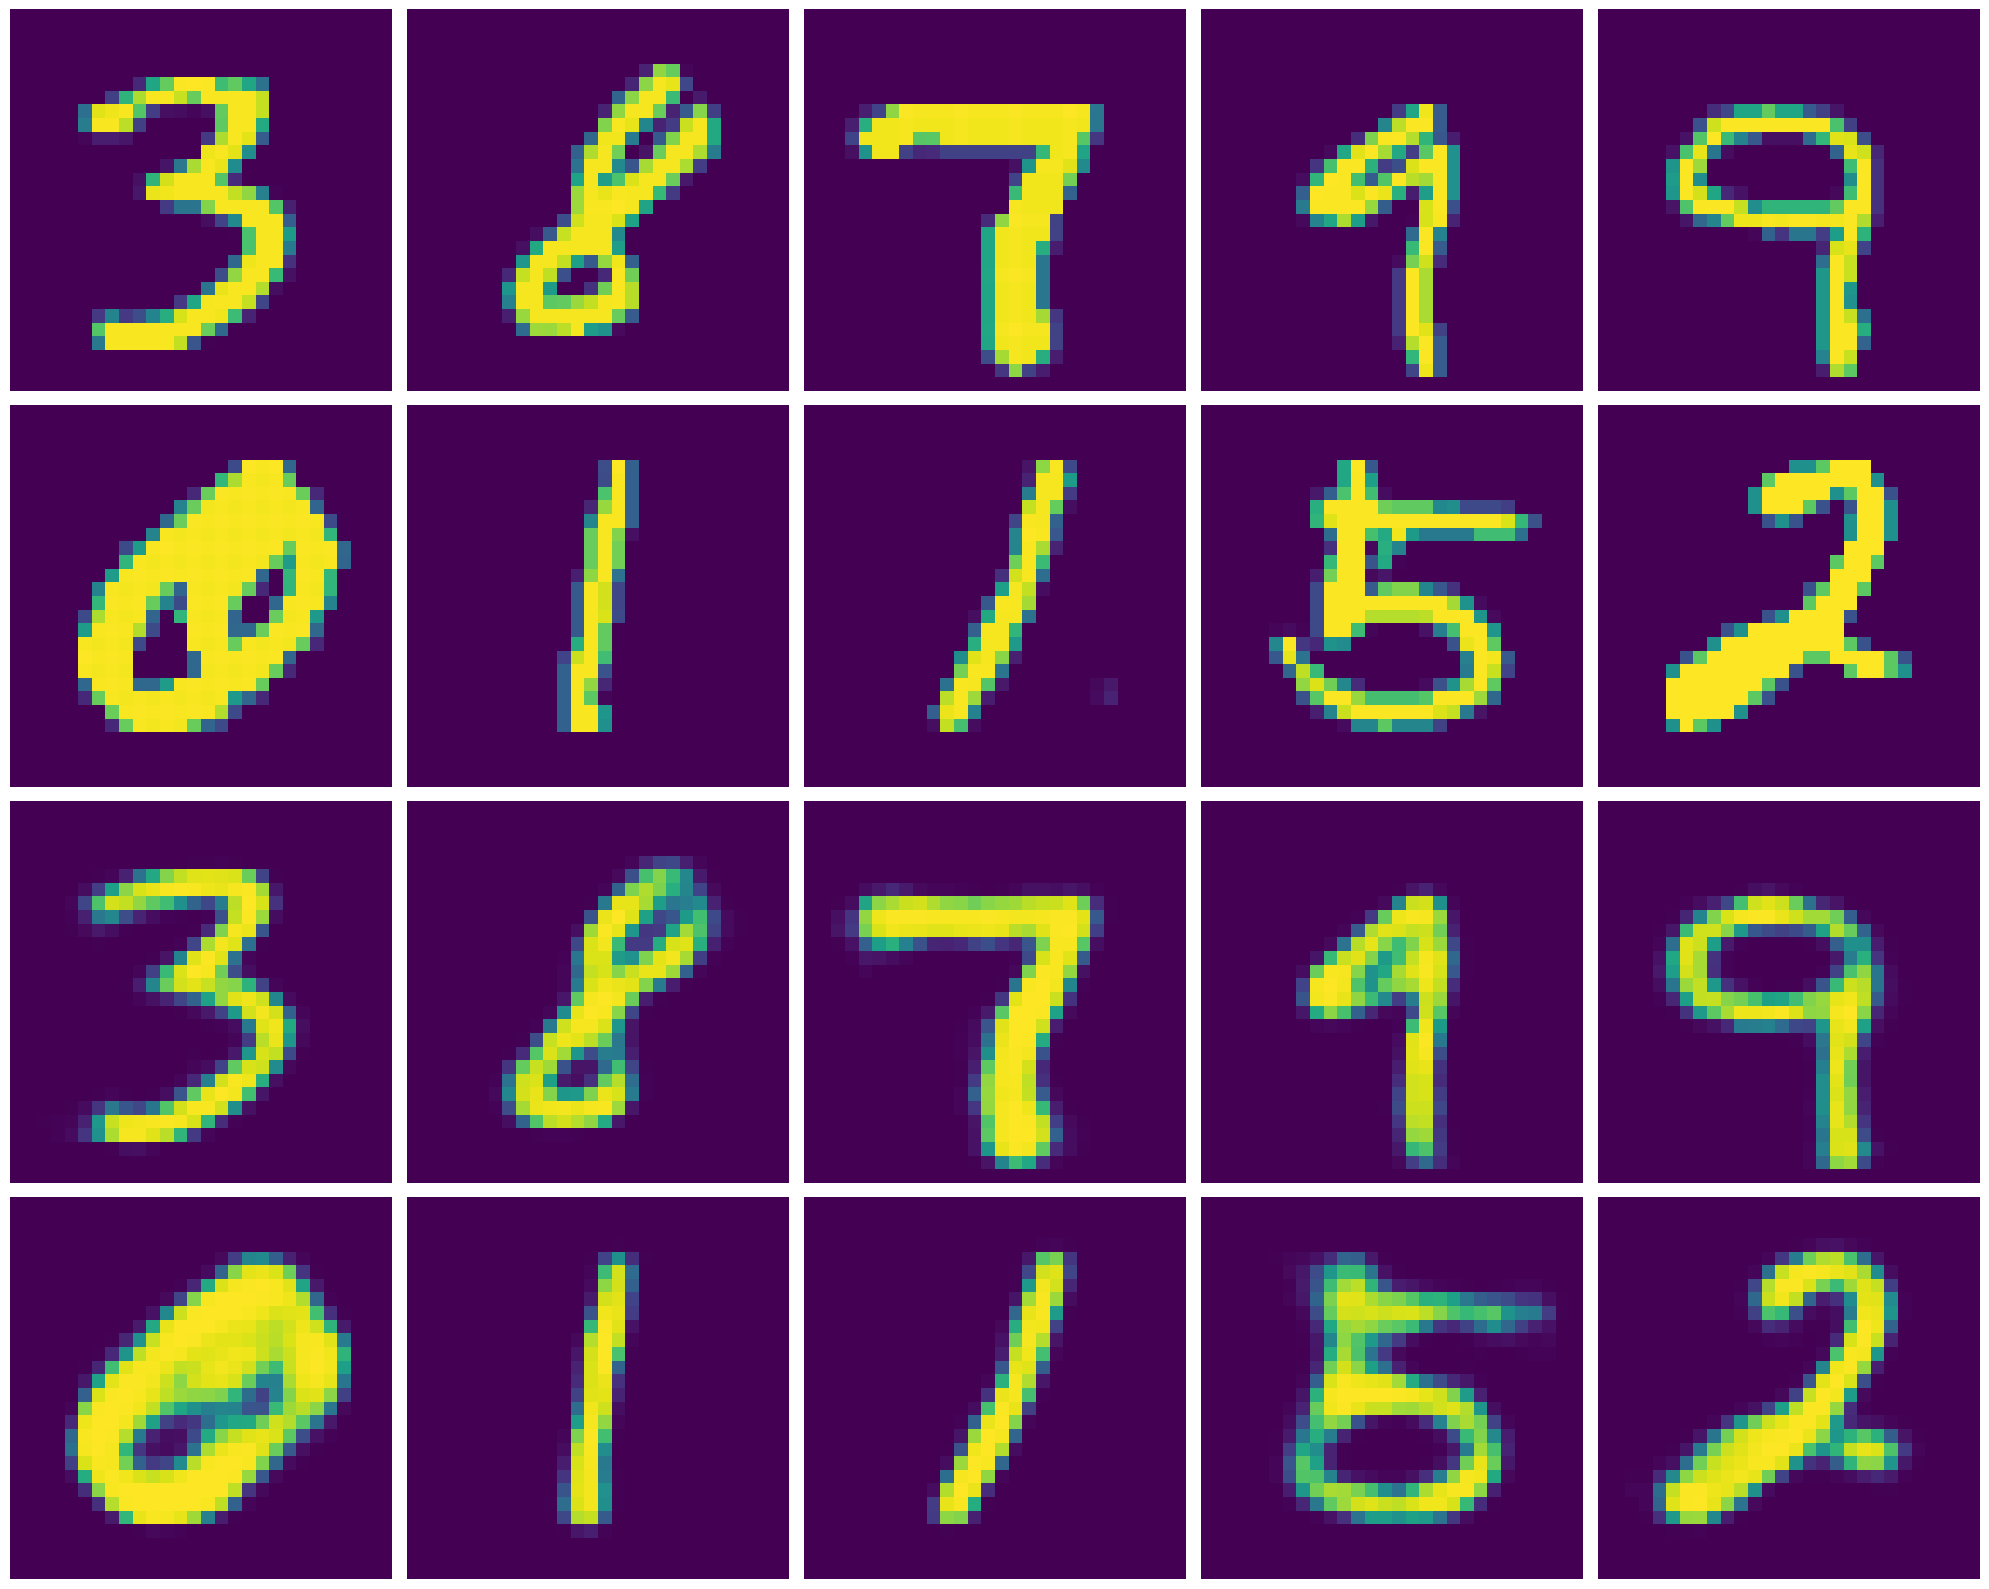

In [53]:
latent_dim = 20

manager = Manager()
manager.prepare_data()
manager.set_model(My_Encoder(latent_dim), My_Decoder(latent_dim))

hist = manager.train(calc_loss, epochs=10)

show_images(manager)

# for seminar

In [1]:
from myAE import Manager

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()
manager.set_default_model(2)

print(manager.model)

Sequential(
  (encoder): My_Encoder(
    (fln): Flatten(start_dim=1, end_dim=-1)
    (l0): Linear(in_features=784, out_features=512, bias=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (l2): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): My_Decoder(
    (l0): Linear(in_features=2, out_features=512, bias=True)
    (l1): Linear(in_features=512, out_features=512, bias=True)
    (l2): Linear(in_features=512, out_features=784, bias=True)
    (unfln): Unflatten(dim=1, unflattened_size=[1, 28, 28])
  )
)


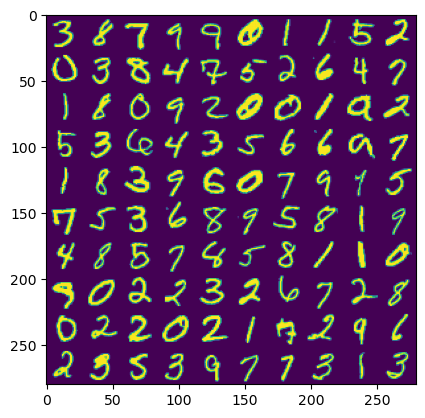

In [35]:
import matplotlib.pyplot as plt
import torch

img = torch.zeros(280, 280)

start = 10000

for i in range(10):
    for j in range(10):
        img[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = manager.training_data.data[start + i * 10 + j].view([28, 28])

plt.imshow(img)


In [8]:
target_indices = [38, 70, 390, 892, 10005]
tartget = manager.training_data.data[target_indices]

In [12]:
def calc_loss(model, x, y, F, device):
    z = model.get_submodule("encoder")(x)
    x_hat = model.get_submodule("decoder")(z)
    loss = F.binary_cross_entropy(x_hat, x, reduction='sum')/len(x)
    return loss

manager = Manager()
manager.prepare_data()
manager.set_default_model(2)

hist = manager.train_on_cpu(calc_loss, epochs=20)

Now, it is working on cpu.


100%|██████████| 20/20 [03:55<00:00, 11.76s/it]


(-0.5, 55.5, 139.5, -0.5)

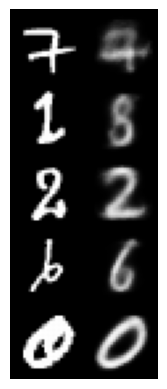

In [13]:
import torch
import matplotlib.pyplot as plt

img = torch.zeros(28 * 5, 28 * 2)

for i in range(5):
    img[i * 28:(i + 1) * 28, :28] = tartget[i].view([28, 28])

with torch.no_grad():
    pred = manager.model(tartget)

for i in range(5):
    img[i * 28:(i + 1) * 28, 28:] = pred[i].view([28, 28])

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [15]:
dims = [2, 4, 8, 16, 32, 64, 128, 256]

img = torch.zeros(28 * 5, 28 * len(dims) + 1)

for i in range(5):
    img[i * 28:(i + 1) * 28, :28] = tartget[i].view([28, 28])
    
for idx, dim in enumerate(dims):
    manager.set_default_model(dim)
    hist = manager.train_on_cpu(calc_loss, epochs=20)

    with torch.no_grad():
        pred = manager.model(tartget)

    for i in range(5):
        img[i * 28:(i + 1) * 28, 28 * (idx + 1):28 * (idx + 2)] = pred[i].view([28, 28])
        

Now, it is working on cpu.


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:54<00:00, 11.73s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [04:10<00:00, 12.55s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [03:56<00:00, 11.85s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [03:58<00:00, 11.91s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [03:59<00:00, 11.99s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [04:01<00:00, 12.06s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [04:03<00:00, 12.19s/it]


Now, it is working on cpu.


100%|██████████| 20/20 [04:13<00:00, 12.67s/it]


RuntimeError: The expanded size of the tensor (1) must match the existing size (28) at non-singleton dimension 1.  Target sizes: [28, 1].  Tensor sizes: [28, 28]

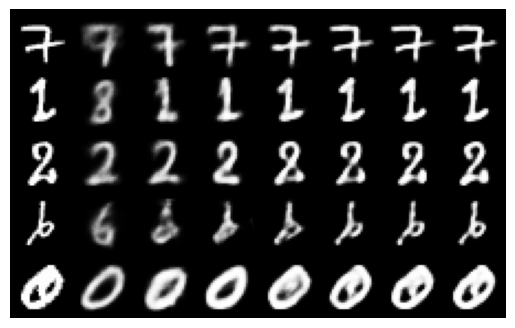

In [20]:
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()